In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, math
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import h5py, pickle, subprocess
import umap, scipy, json 
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable

2024-05-30 11:53:54.883152: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 11:53:54.967384: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 11:54:02.892604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from sklearn.datasets import make_classification, make_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LassoCV
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

In [3]:
wellsInfo = 'Awells'
conditions = ['A2'] # LIGANDS or CONDITIONS
tmSet = ['EGF1']
n_conditions = len(tmSet) # Total number of Ligand Conditions
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = f"{sysName}_{date2day}"

In [4]:
# Indices for the ligands 
inds_tmSet = [i for i in range(n_conditions)]
inds_tmSet = np.array(inds_tmSet).astype(int)
nfovs = 1
fovs = [i for i in range(1, nfovs + 1)]
fovs = np.array(fovs).astype(int)
dateSet = ['']
pathSet = ['/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/']
imagingSet = [0 for i in range(n_conditions)]
modelList = [None]*(nfovs*(n_conditions))
modelList_conditions = np.zeros(nfovs*(n_conditions)).astype(int)

In [5]:
i = 0
icond = 0
for cond in conditions:
    modelList_conditions[i] = icond
    modelList[i] = pathSet[imagingSet[icond]]+sysName+'_'+cond+'_'+str(fovs[0])+dateSet[imagingSet[icond]]
    #print("Models: ",modelList[i])
    i = i + 1
    icond = icond + 1

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [6]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print(f"loaded {objFile} with {modelSet[i].cells_indSet.size} cells")
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models,i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1.obj with 51054 cells


In [7]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [8]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [9]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)

# get cell counts
n_conds = len(tmSet)
inds_tmSet_models = np.zeros(nmodels).astype(int)
inds_imagingSet_models = np.zeros(nmodels).astype(int)
i = 0
icond = 0
for cond in conditions:
    inds_tmSet_models[i] = inds_tmSet[icond] # Assign indices "tmSet" to all FOVs
    inds_imagingSet_models[i] = imagingSet[icond]
    icond = icond + 1

In [10]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0 #just replace with zeros for now? Not sure best...

In [11]:
nfeat_com = 3
Xf_com0 = np.zeros((0, nfeat_com))
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [12]:
wctm = cellTraj.Trajectory() # import Trajectory object 
# Cell features: Zernike (49), Haralick (13), Shape (15), Boundary (15) --> total 92
n_features = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, n_features))
indtreatment = np.array([])
indcellSet = np.array([])
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
        # Indices for each model for later access using them
        indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
        indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [13]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        indsf = np.where(indtreatment == i)[0]
        modelSet[i].Xf_rfe = Xf[indsf, :]

indgood_models = indgood_models[np.where(inds_imagingSet_models[indgood_models] == 0)[0]]

In [14]:
self = wctm
all_trajSet = [None]*nmodels
for i in indgood_models:
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

tracked cell 50891, 25 tracks, 46600 left
tracked cell 50763, 23 tracks, 42400 left
tracked cell 50735, 51 tracks, 41500 left
tracked cell 50076, 1 tracks, 37700 left
tracked cell 49741, 1 tracks, 37600 left
tracked cell 49307, 1 tracks, 37500 left
tracked cell 49056, 18 tracks, 37400 left
tracked cell 48763, 1 tracks, 37100 left
tracked cell 48214, 1 tracks, 36900 left
tracked cell 48008, 1 tracks, 36800 left
tracked cell 47562, 1 tracks, 36500 left
tracked cell 46286, 1 tracks, 35900 left
tracked cell 46119, 3 tracks, 35700 left
tracked cell 45624, 1 tracks, 35600 left
tracked cell 42924, 7 tracks, 34200 left
tracked cell 41889, 2 tracks, 33800 left
tracked cell 41728, 1 tracks, 33700 left
tracked cell 40948, 1 tracks, 33300 left
tracked cell 39770, 1 tracks, 32900 left
tracked cell 39018, 1 tracks, 32500 left
tracked cell 38257, 1 tracks, 32300 left
tracked cell 38063, 6 tracks, 32200 left
tracked cell 37504, 1 tracks, 32000 left
tracked cell 35855, 2 tracks, 31300 left
tracked cell

In [15]:
# Single-cell trajectories over the cell features
Xf_rfet = np.zeros((0, n_features + nfeat_com))
indtreatment_traj = np.array([])
for i in indgood_models:
    print('building trajectory data for model {}...'.format(i))
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    n_trajs_model = len(modelSet[i].trajectories) 
    data_traj = []
    for ind_traj in range(n_trajs_model):
        cell_traj = modelSet[i].trajectories[ind_traj]
        data = modelSet[i].Xf_rfe[cell_traj, :]
        datacom = modelSet[i].Xf_com[cell_traj, :]
        data = np.append(data, datacom, axis = 1)
        data_traj.extend(data)
    data_traj = np.array(data_traj)
    indgood = np.where(np.sum(np.isnan(data_traj), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data_traj = data_traj[indgood, :] 
    Xf_rfet = np.append(Xf_rfet, data_traj, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data_traj.shape[0])) # Indices of Treatments (Models) Along Trajectories 

building trajectory data for model 0...


In [16]:
# Get Cross correlations & respective frame numbers along all single-cell trajectories
def get_cross_corr_all_single_cell_trajs(filename):
      cross_corr_sctraj = []
      frame_num_sctraj = []
      with open(filename, 'r') as file_in:
          # Create an iterator over the file lines 
          file_iter = iter(file_in)
          try:
              while True:
                  # Read two lines at a time: Cross correlations & the corresponding frame numbers
                  line1 = next(file_iter).strip()
                  if line1:
                          data = ast.literal_eval(line1)
                          cross_corr_sctraj.append(data)
                          line2 = next(file_iter).strip()
                          # Parse line2 as a list of integers
                          frame_numbers = ast.literal_eval(line2)   
                          frame_num_sctraj.append(frame_numbers)
          except StopIteration:
              # End of file reached
              pass
      cross_corr_all_sctraj_file = cross_corr_sctraj
      frame_num_all_sctraj_file = frame_num_sctraj
      
      return cross_corr_all_sctraj_file, frame_num_all_sctraj_file

In [46]:
# Get cross-correlation values along all single-cell trajectories (sorted as per trajectory length) 
cc_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/dcompCCtraj_states/'
cc_filename = f"{cc_path}{sysName}_{conditions[0]}_1.dat"
cross_correlations, frame_numbers = get_cross_corr_all_single_cell_trajs(cc_filename)

In [19]:
for i in indgood_models:
    cc_all_trajs_model = []
    for j in range(len(cross_correlations)):
        cc_all_trajs_model.extend(cross_correlations[j])
    cc_all_trajs_model = np.array(cc_all_trajs_model)
    cc_all_trajs_model = cc_all_trajs_model[indgood]

In [20]:
X = Xf_rfet
y = cc_all_trajs_model

<Figure size 640x480 with 0 Axes>

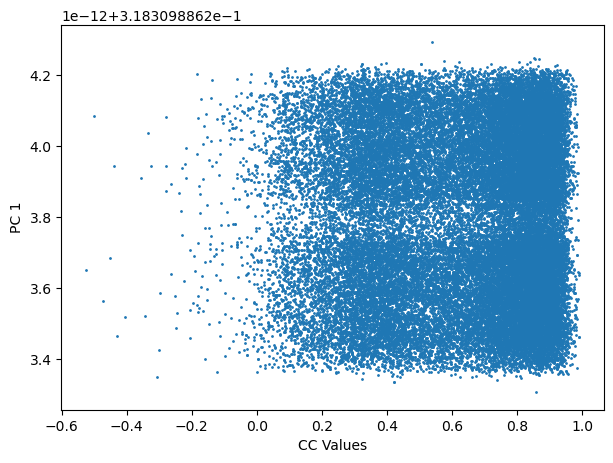

<Figure size 640x480 with 0 Axes>

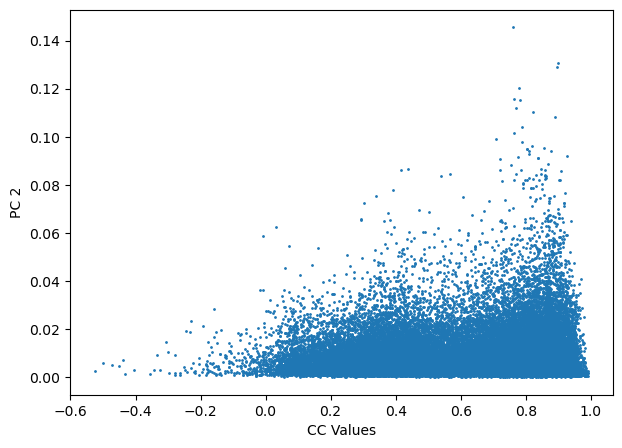

<Figure size 640x480 with 0 Axes>

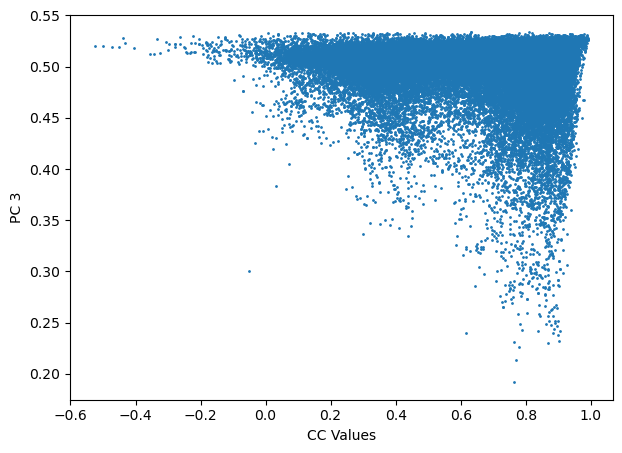

<Figure size 640x480 with 0 Axes>

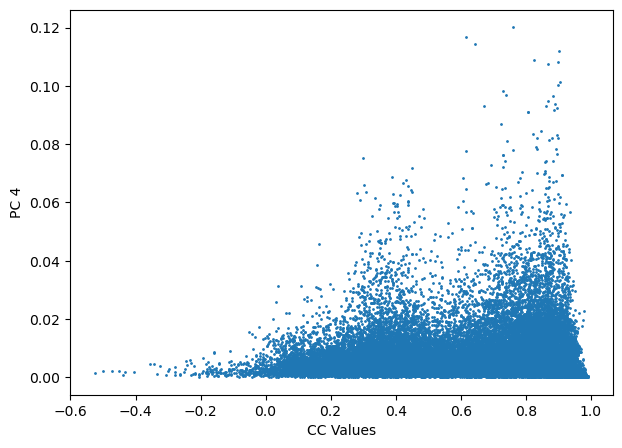

<Figure size 640x480 with 0 Axes>

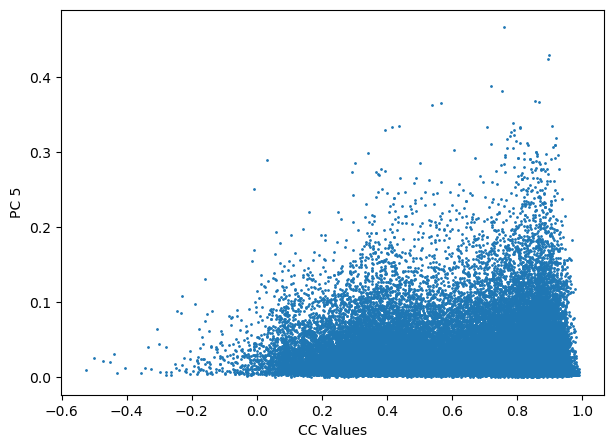

<Figure size 640x480 with 0 Axes>

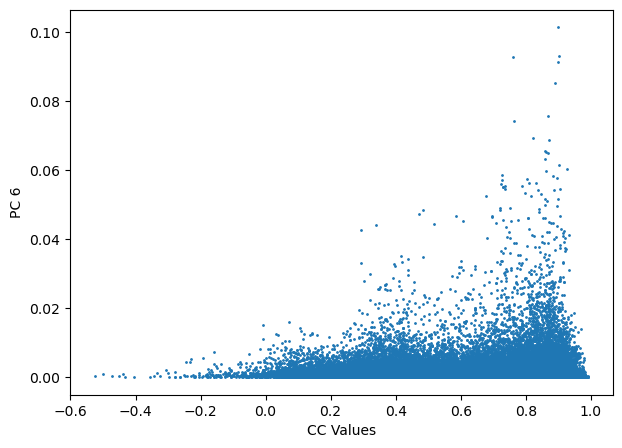

<Figure size 640x480 with 0 Axes>

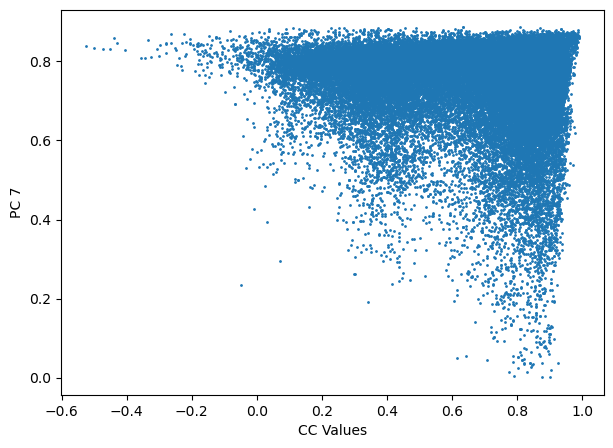

<Figure size 640x480 with 0 Axes>

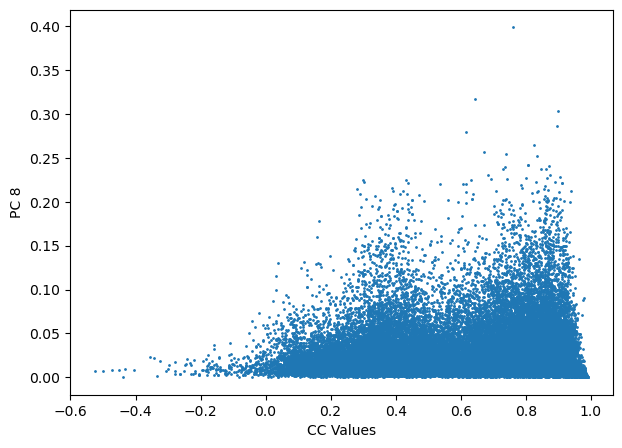

<Figure size 640x480 with 0 Axes>

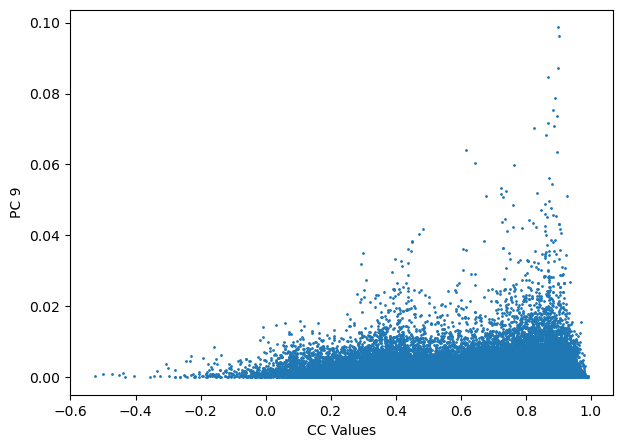

<Figure size 640x480 with 0 Axes>

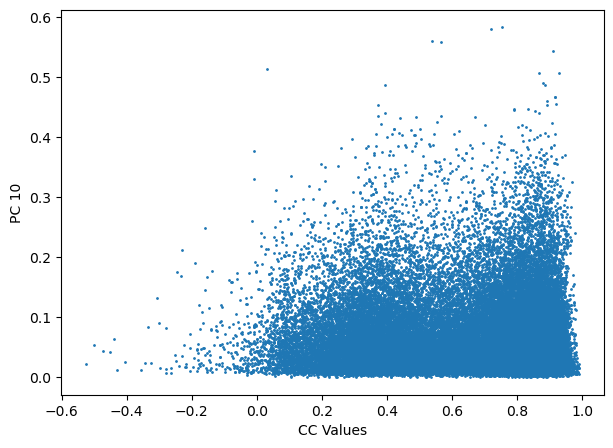

<Figure size 640x480 with 0 Axes>

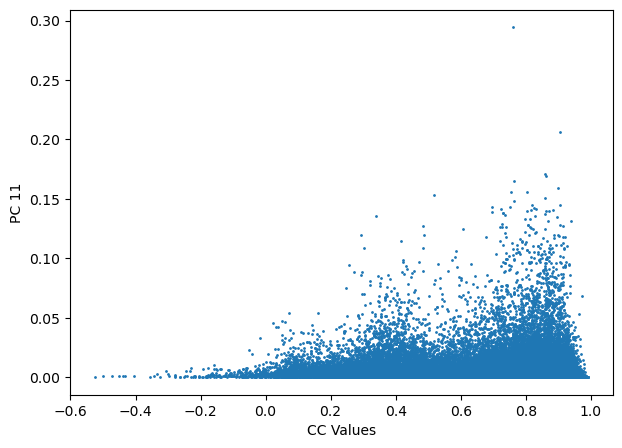

<Figure size 640x480 with 0 Axes>

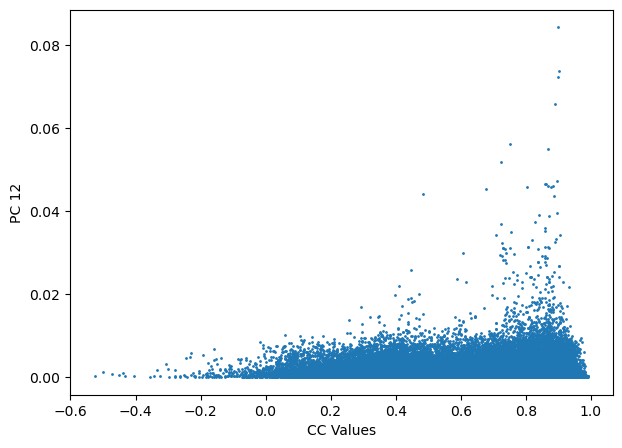

<Figure size 640x480 with 0 Axes>

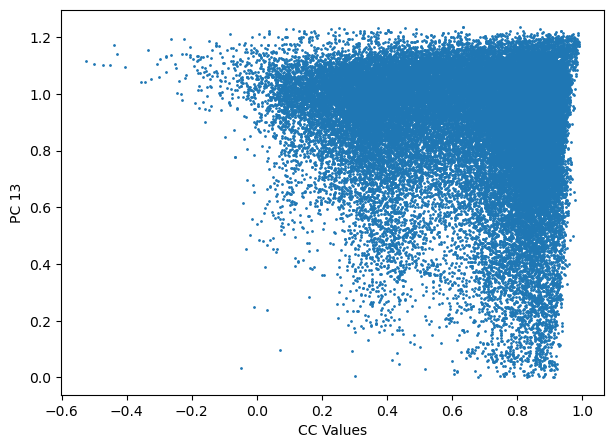

<Figure size 640x480 with 0 Axes>

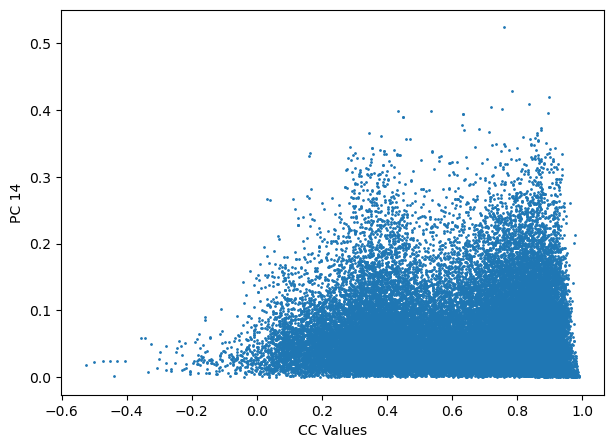

<Figure size 640x480 with 0 Axes>

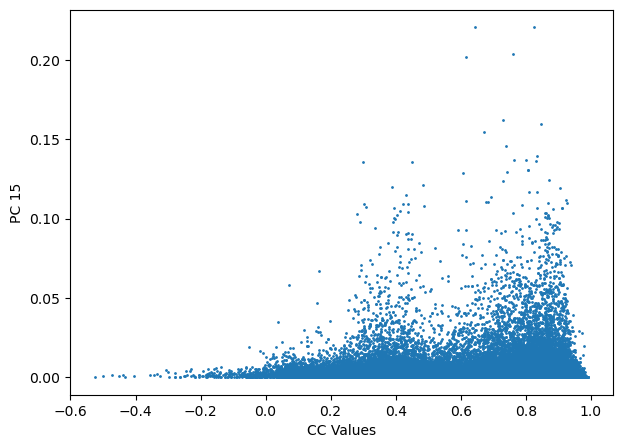

<Figure size 640x480 with 0 Axes>

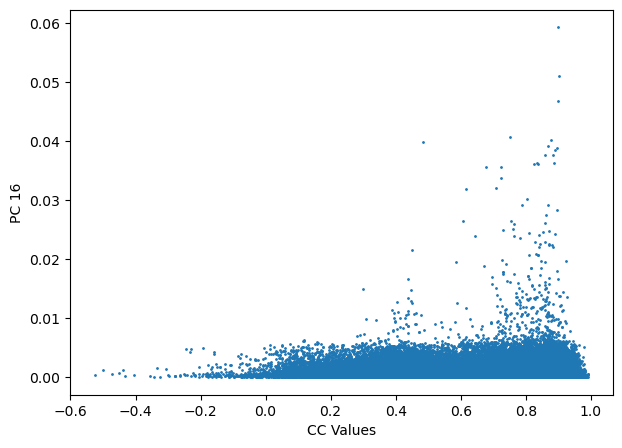

<Figure size 640x480 with 0 Axes>

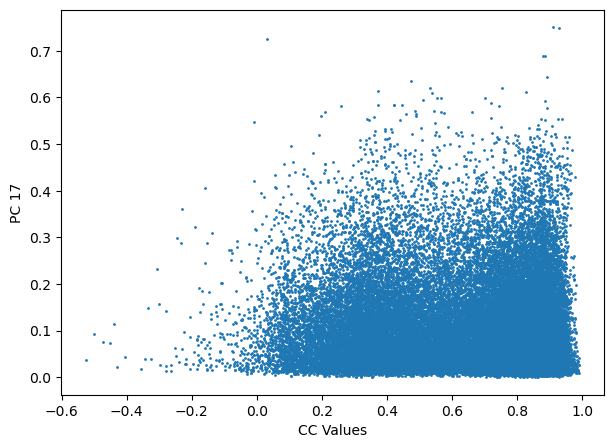

<Figure size 640x480 with 0 Axes>

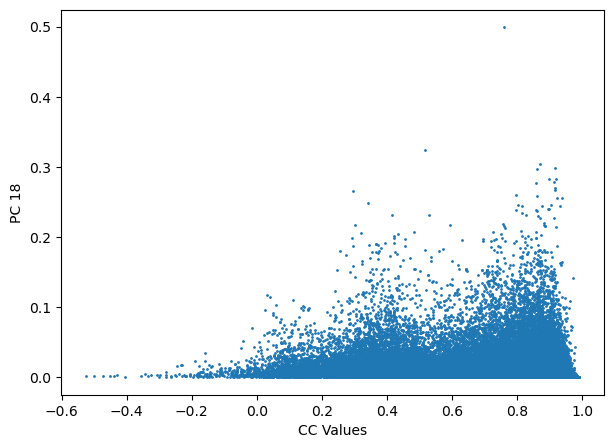

<Figure size 640x480 with 0 Axes>

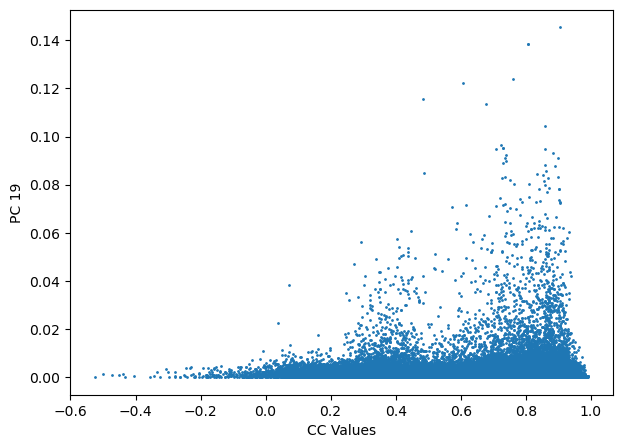

<Figure size 640x480 with 0 Axes>

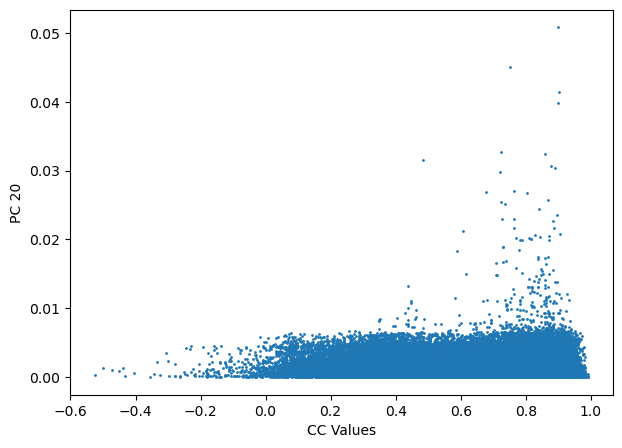

<Figure size 640x480 with 0 Axes>

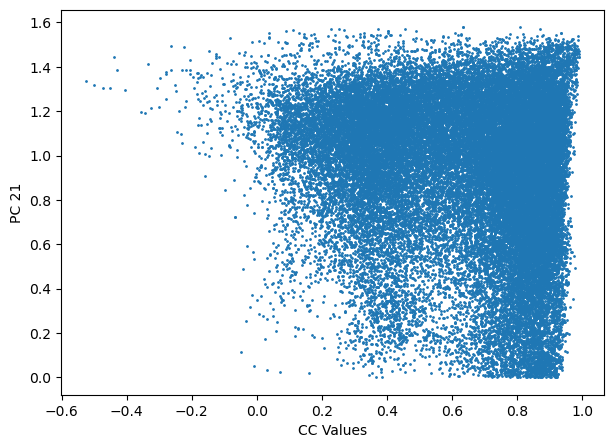

<Figure size 640x480 with 0 Axes>

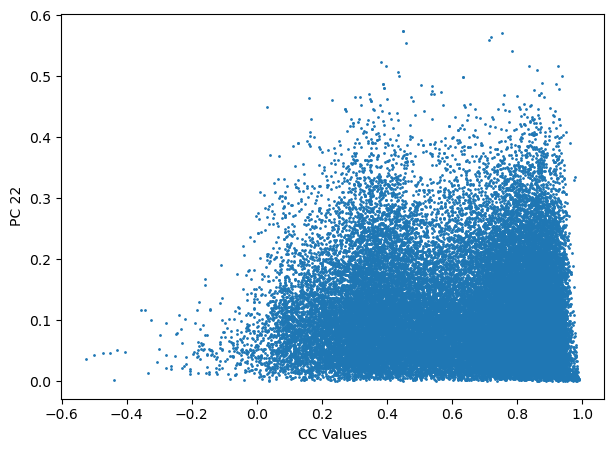

<Figure size 640x480 with 0 Axes>

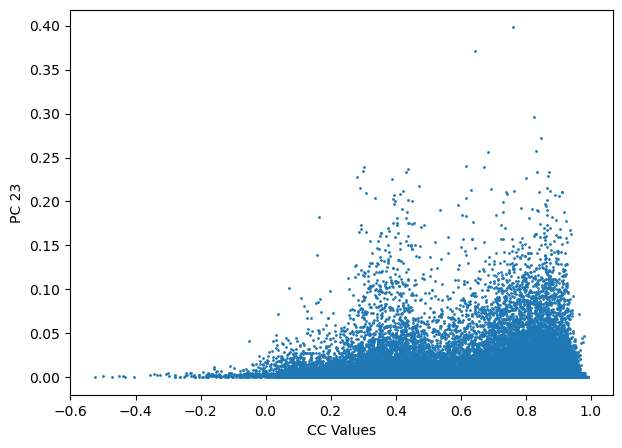

<Figure size 640x480 with 0 Axes>

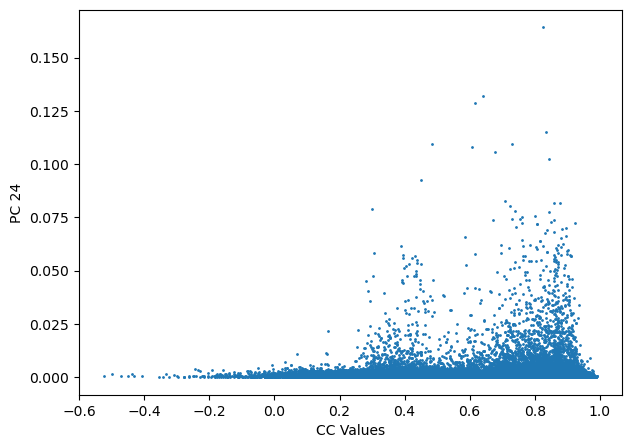

<Figure size 640x480 with 0 Axes>

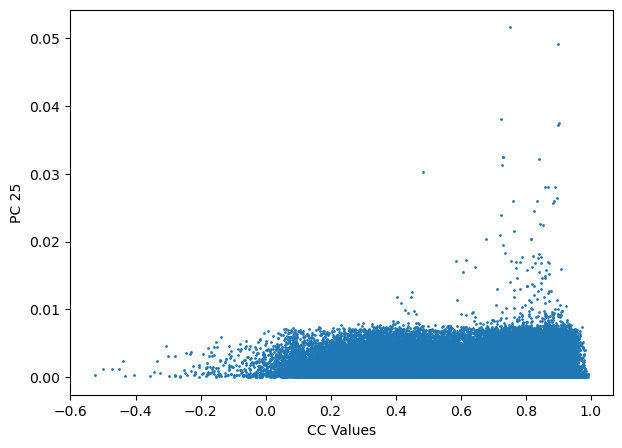

<Figure size 640x480 with 0 Axes>

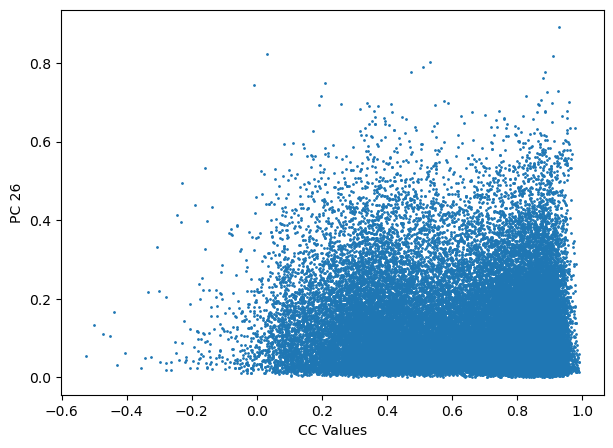

<Figure size 640x480 with 0 Axes>

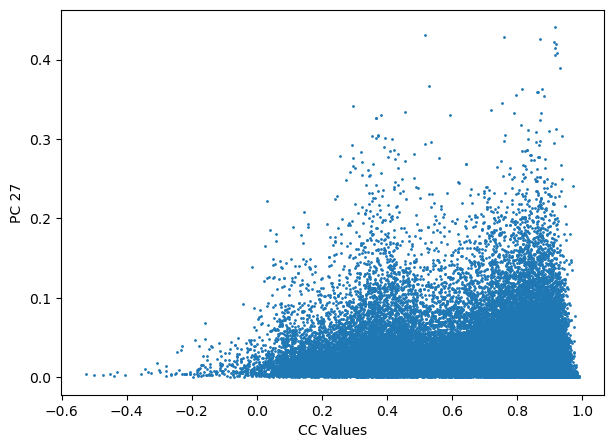

<Figure size 640x480 with 0 Axes>

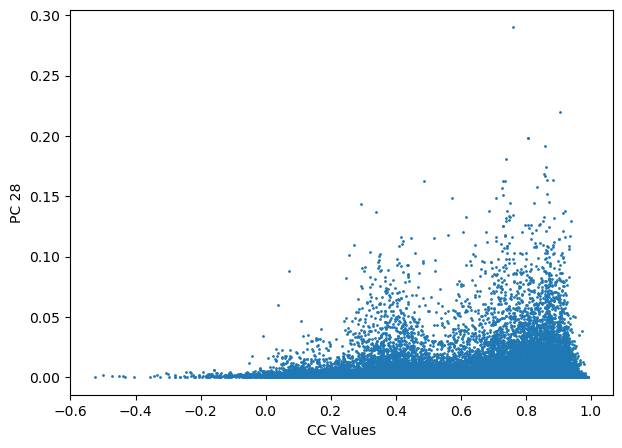

<Figure size 640x480 with 0 Axes>

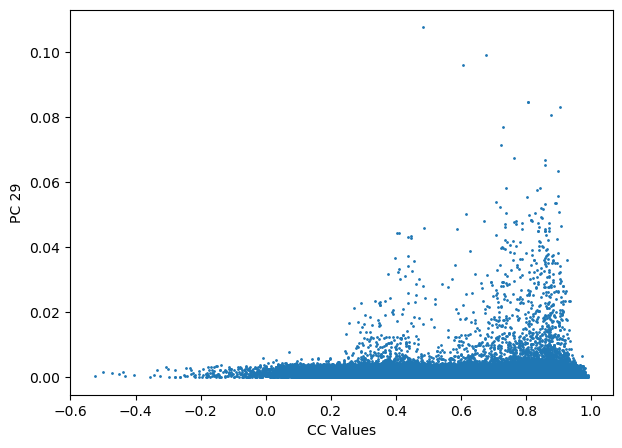

<Figure size 640x480 with 0 Axes>

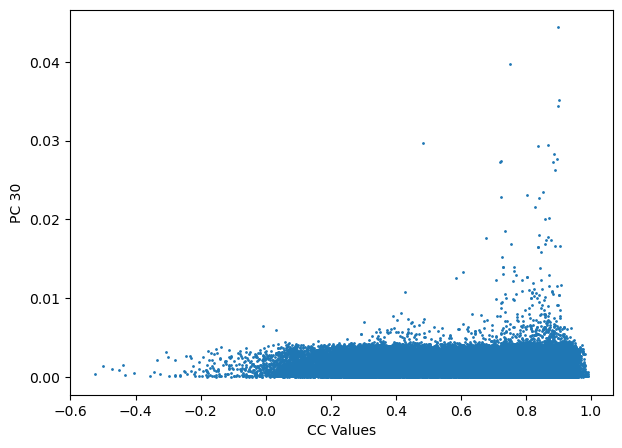

<Figure size 640x480 with 0 Axes>

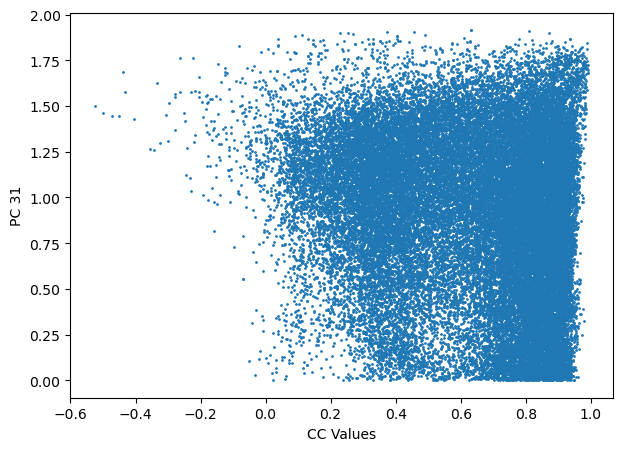

<Figure size 640x480 with 0 Axes>

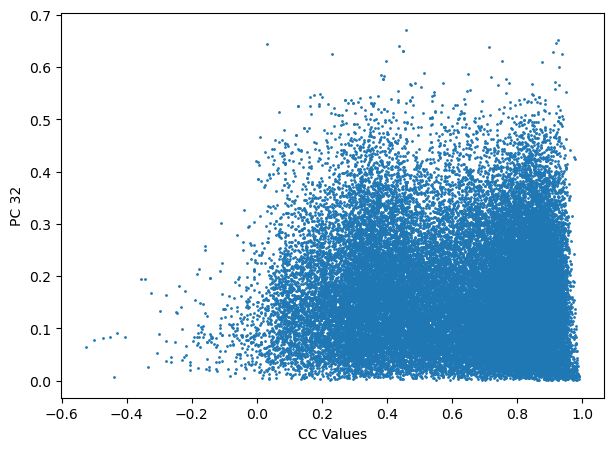

<Figure size 640x480 with 0 Axes>

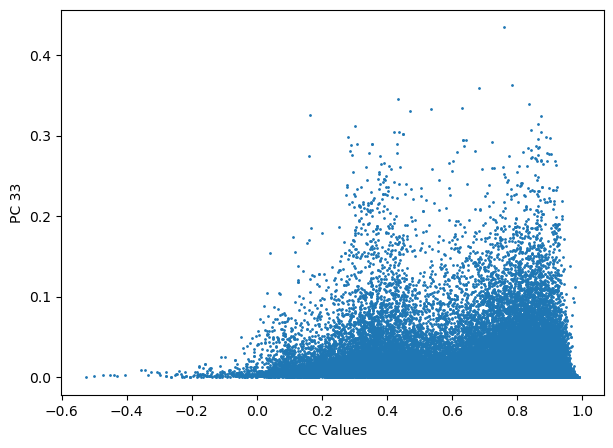

<Figure size 640x480 with 0 Axes>

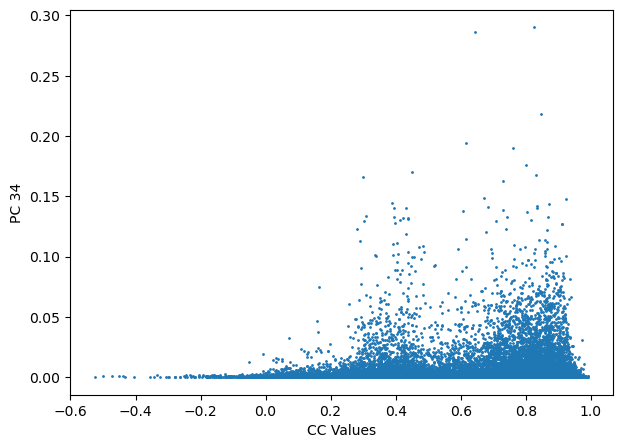

<Figure size 640x480 with 0 Axes>

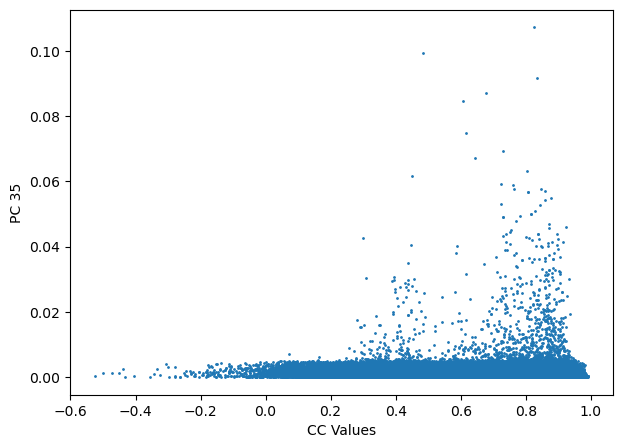

<Figure size 640x480 with 0 Axes>

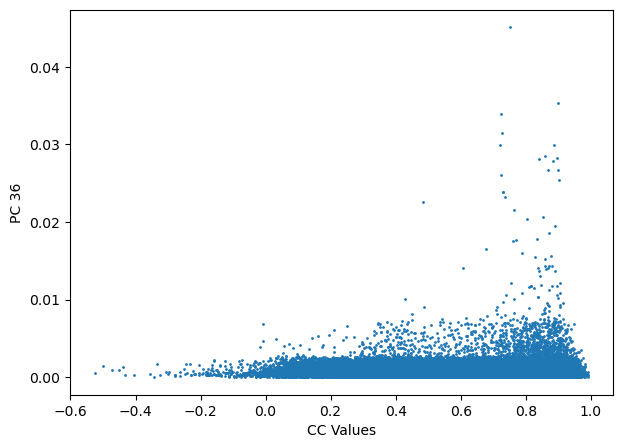

<Figure size 640x480 with 0 Axes>

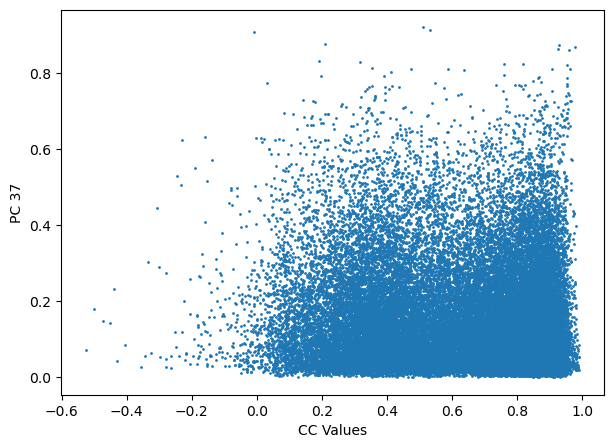

<Figure size 640x480 with 0 Axes>

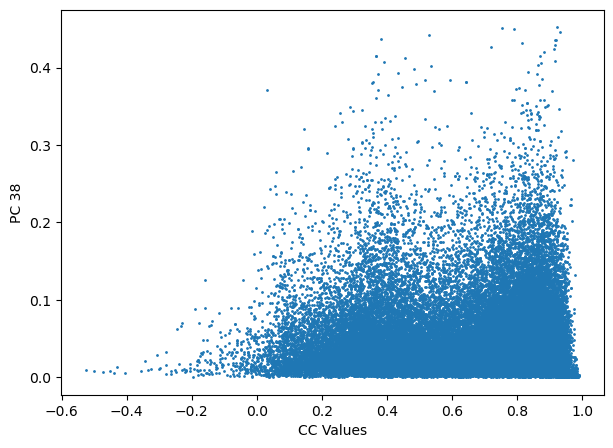

<Figure size 640x480 with 0 Axes>

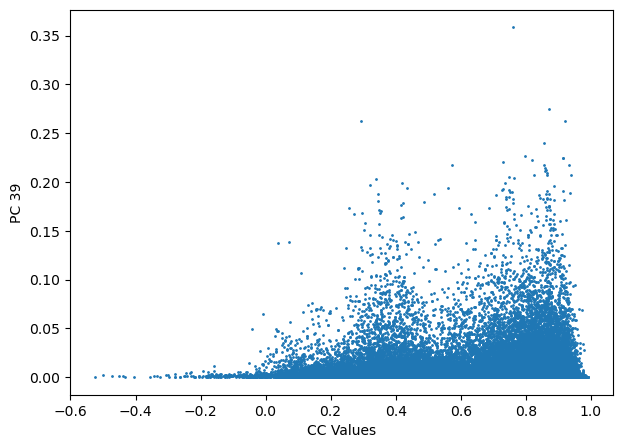

<Figure size 640x480 with 0 Axes>

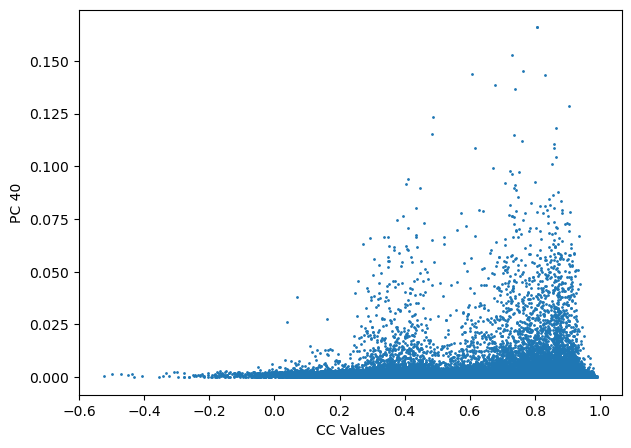

<Figure size 640x480 with 0 Axes>

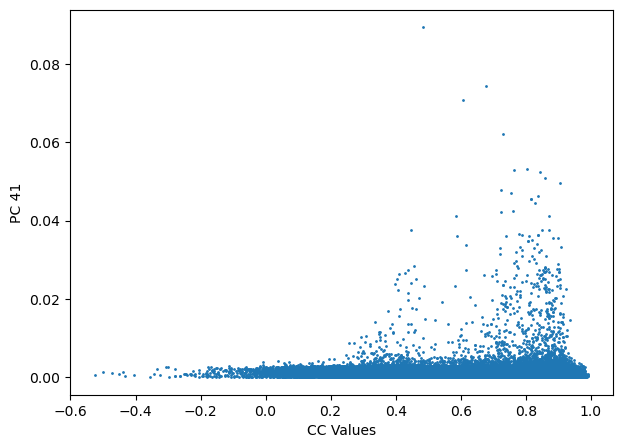

<Figure size 640x480 with 0 Axes>

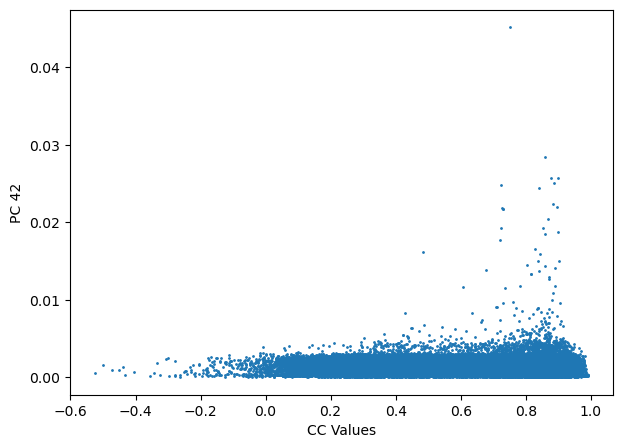

<Figure size 640x480 with 0 Axes>

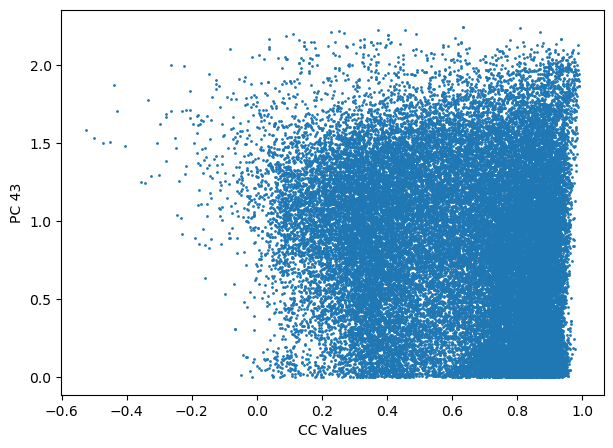

<Figure size 640x480 with 0 Axes>

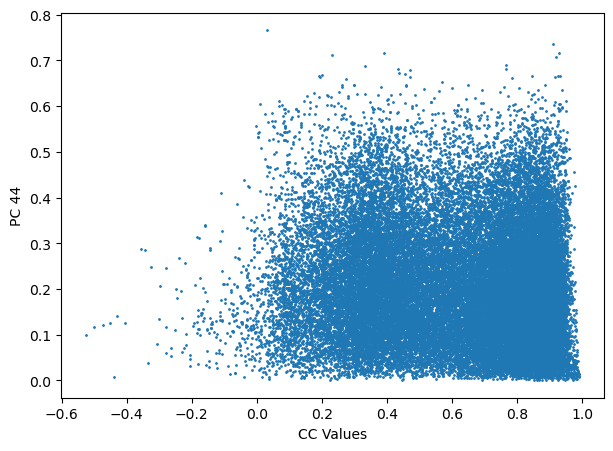

<Figure size 640x480 with 0 Axes>

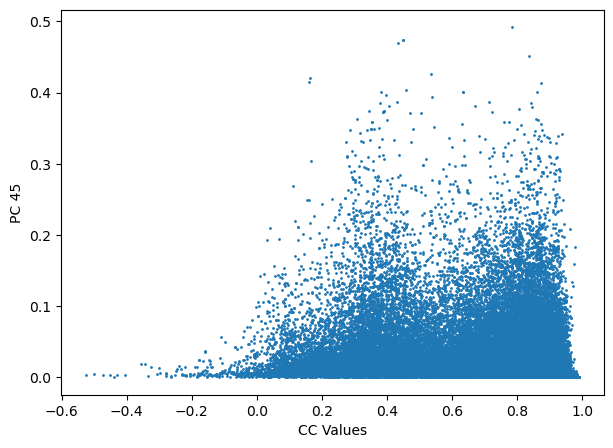

<Figure size 640x480 with 0 Axes>

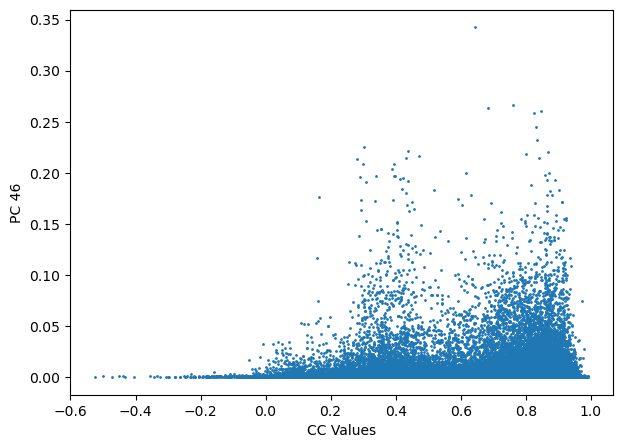

<Figure size 640x480 with 0 Axes>

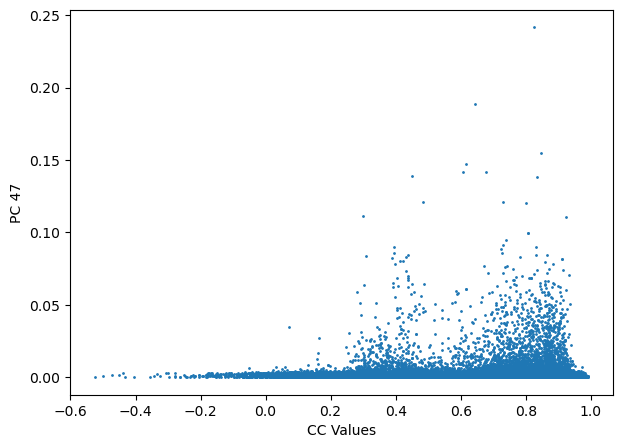

<Figure size 640x480 with 0 Axes>

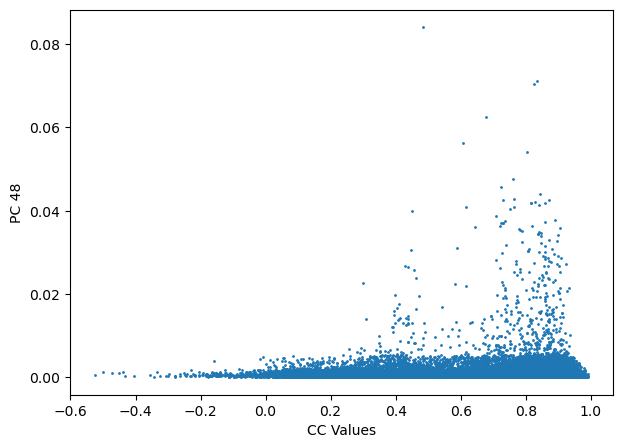

<Figure size 640x480 with 0 Axes>

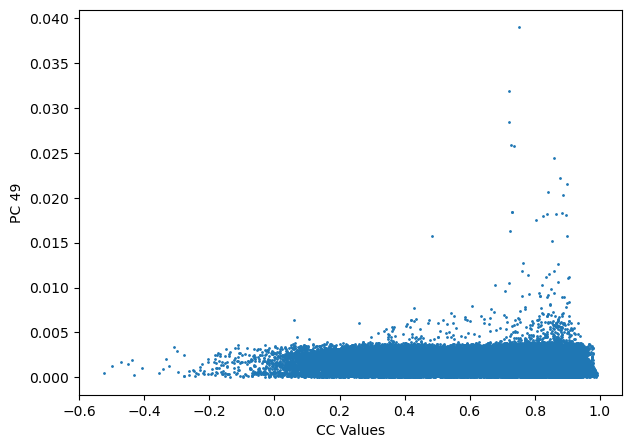

<Figure size 640x480 with 0 Axes>

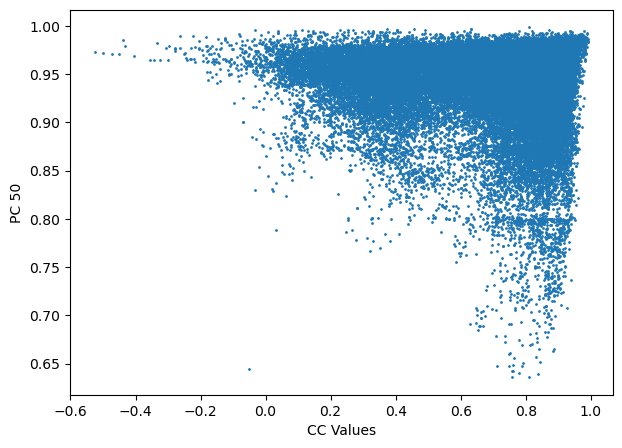

<Figure size 640x480 with 0 Axes>

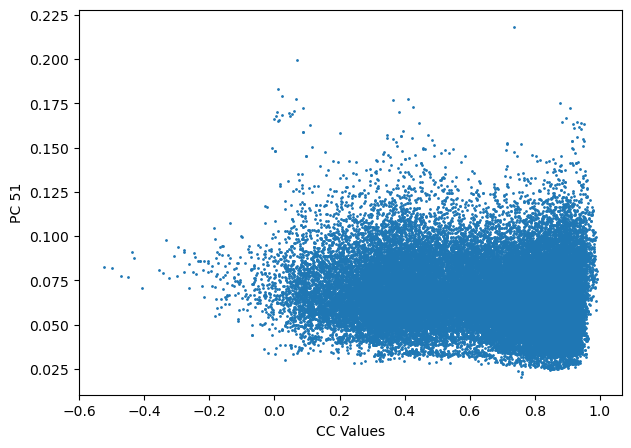

<Figure size 640x480 with 0 Axes>

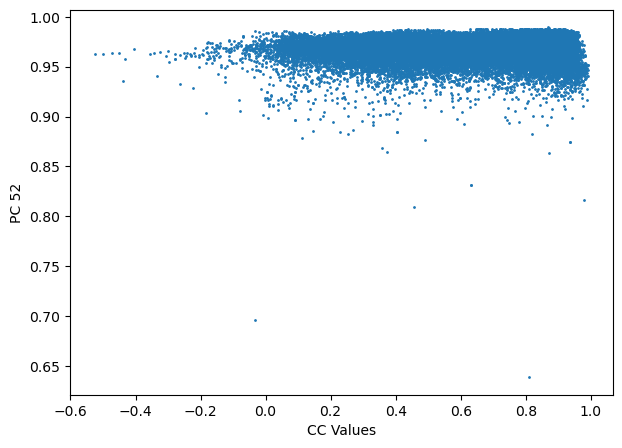

<Figure size 640x480 with 0 Axes>

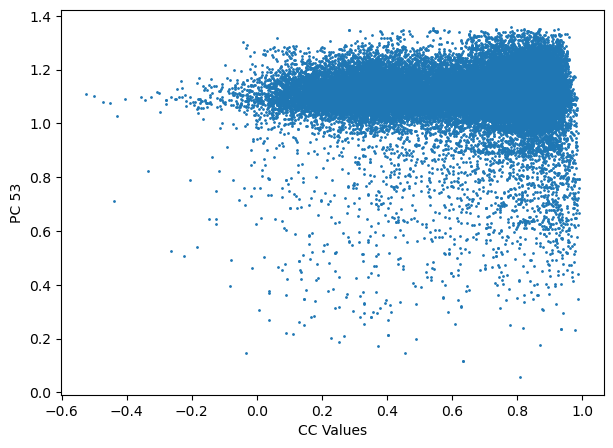

<Figure size 640x480 with 0 Axes>

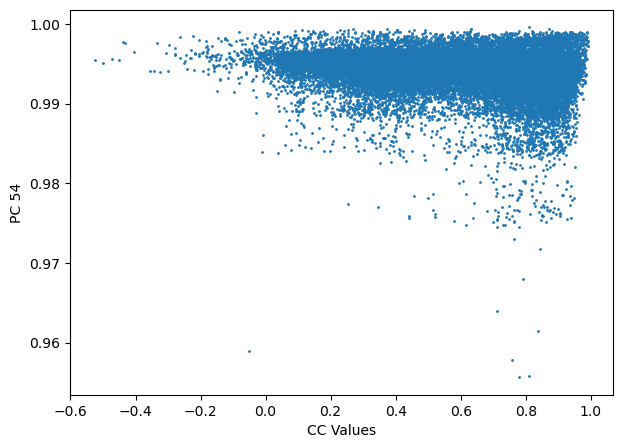

<Figure size 640x480 with 0 Axes>

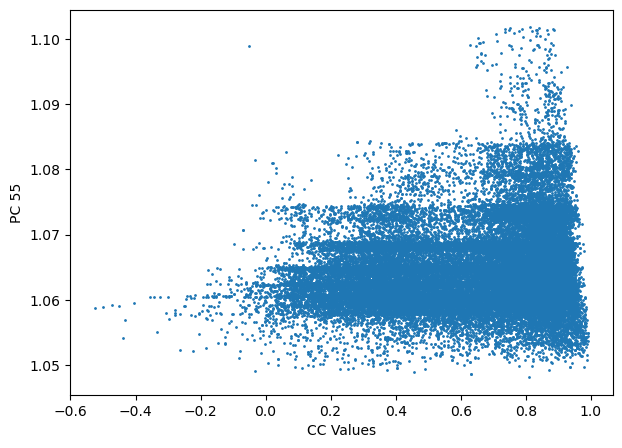

<Figure size 640x480 with 0 Axes>

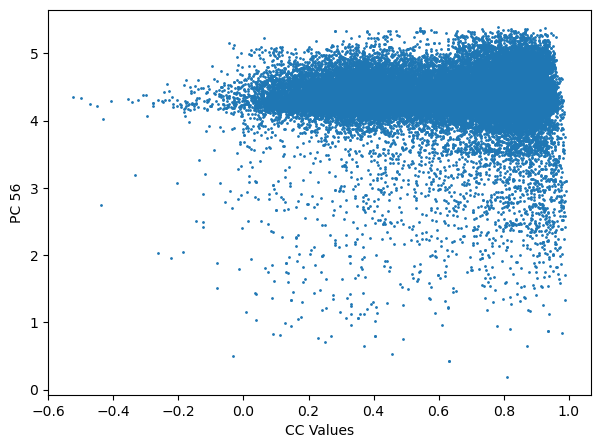

<Figure size 640x480 with 0 Axes>

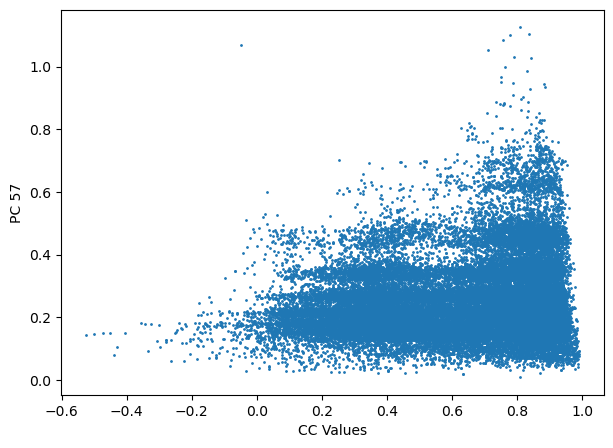

<Figure size 640x480 with 0 Axes>

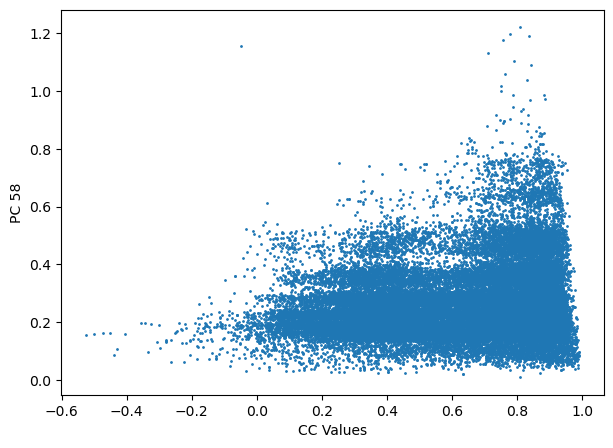

<Figure size 640x480 with 0 Axes>

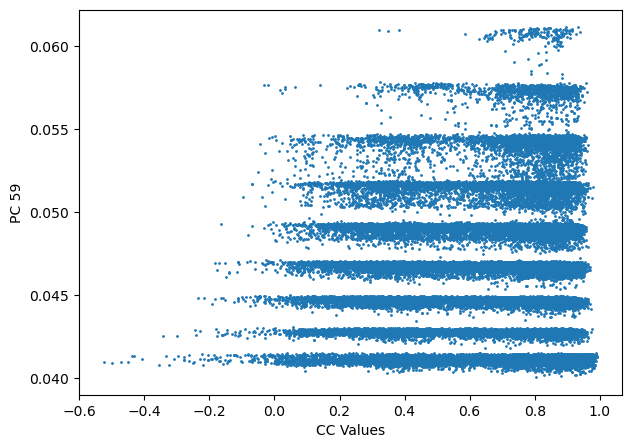

<Figure size 640x480 with 0 Axes>

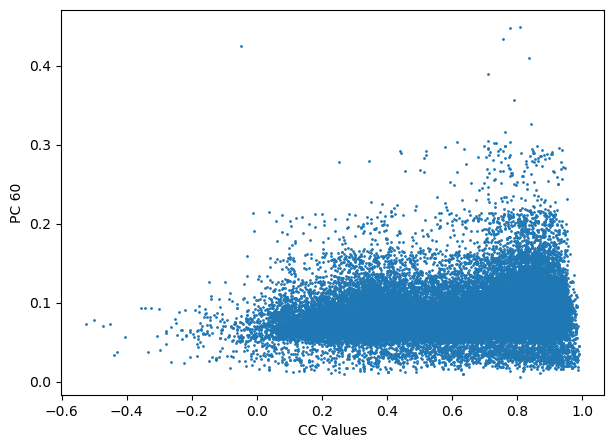

<Figure size 640x480 with 0 Axes>

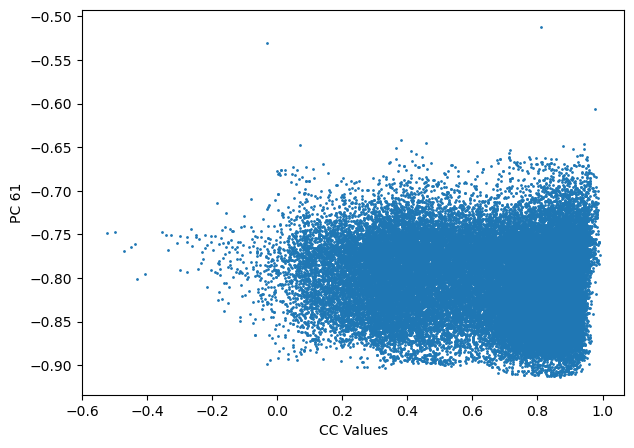

<Figure size 640x480 with 0 Axes>

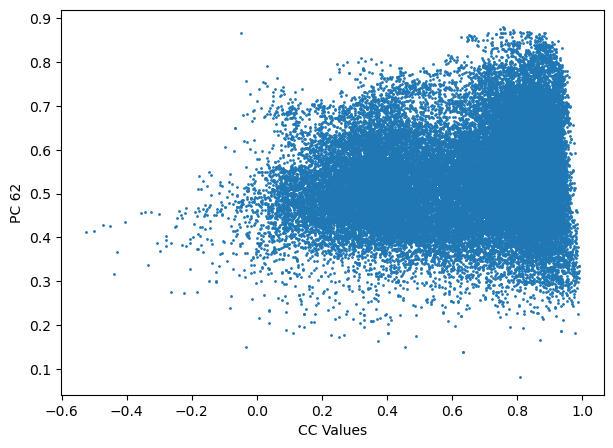

<Figure size 640x480 with 0 Axes>

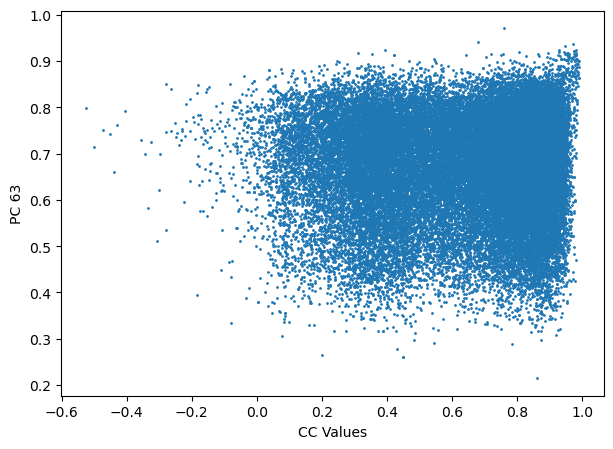

<Figure size 640x480 with 0 Axes>

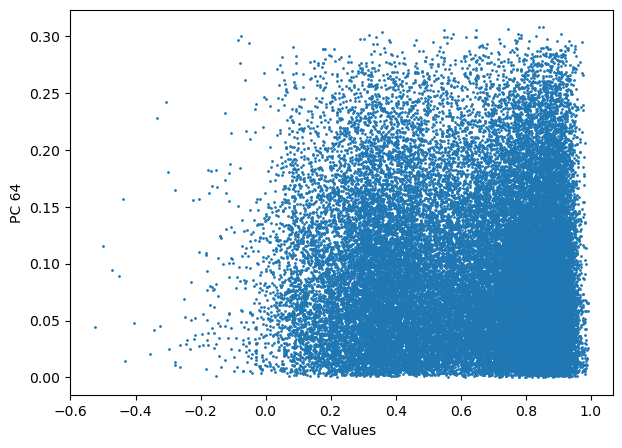

<Figure size 640x480 with 0 Axes>

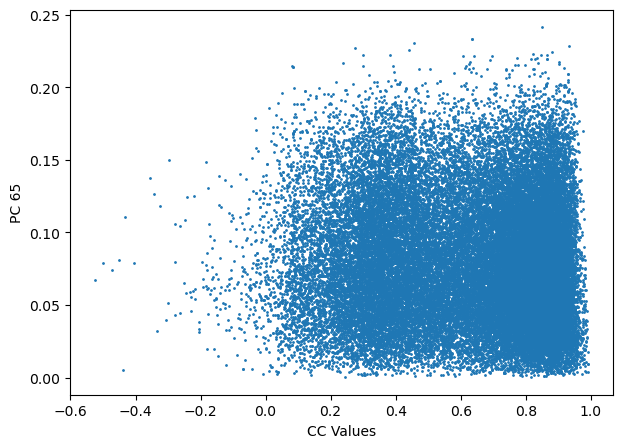

<Figure size 640x480 with 0 Axes>

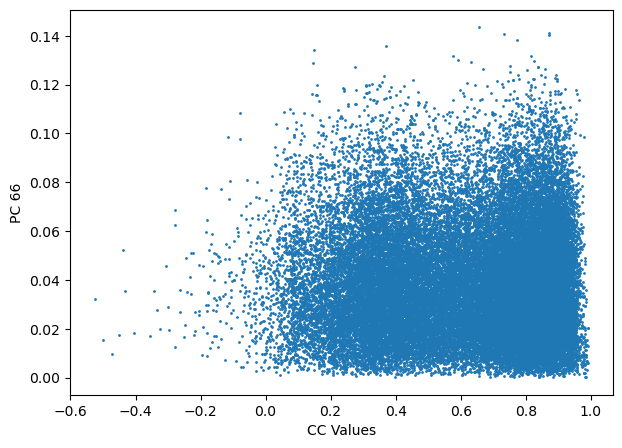

<Figure size 640x480 with 0 Axes>

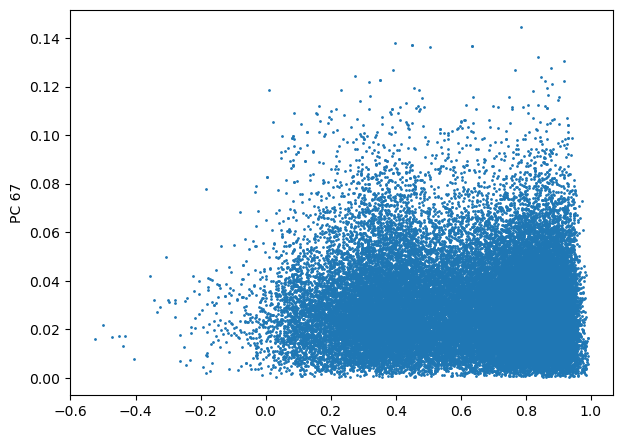

<Figure size 640x480 with 0 Axes>

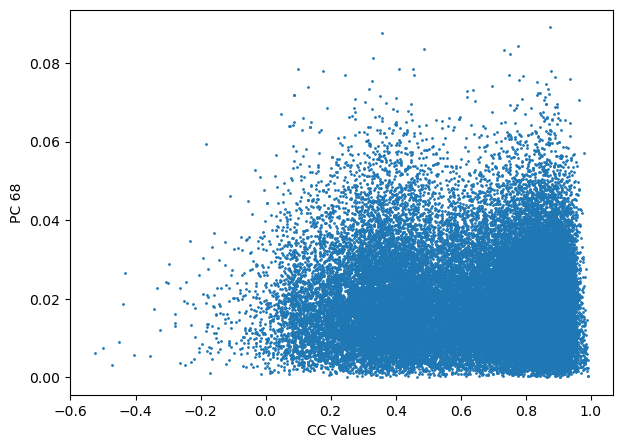

<Figure size 640x480 with 0 Axes>

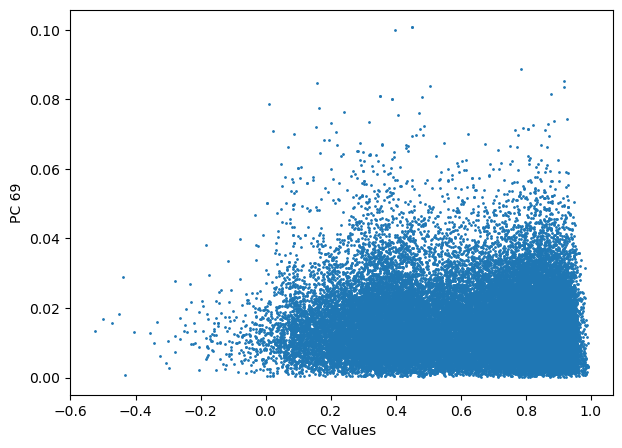

<Figure size 640x480 with 0 Axes>

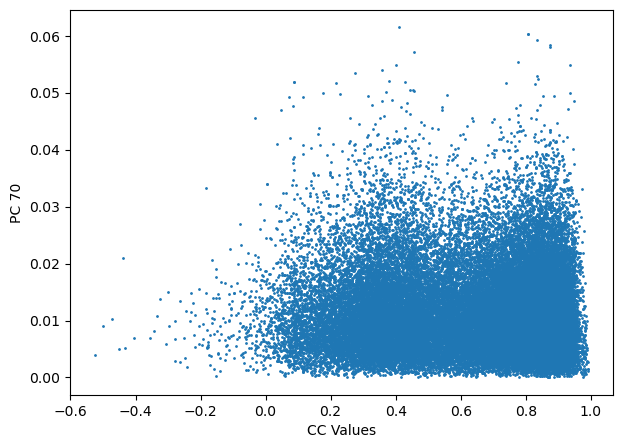

<Figure size 640x480 with 0 Axes>

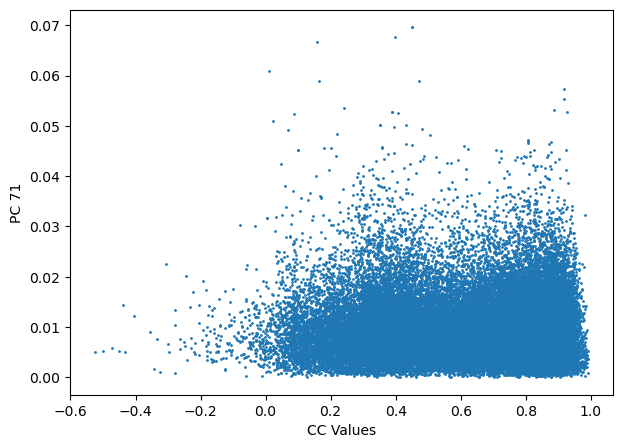

<Figure size 640x480 with 0 Axes>

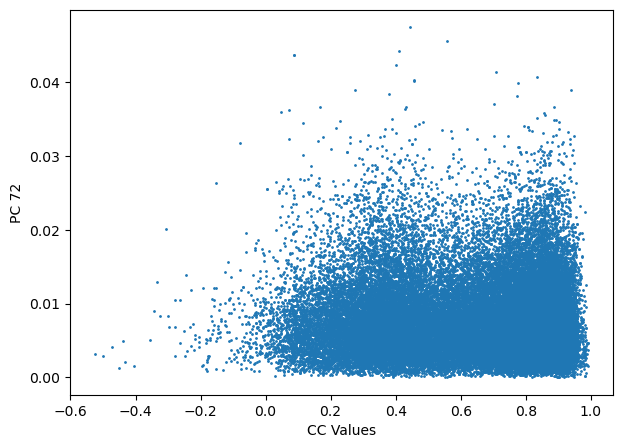

<Figure size 640x480 with 0 Axes>

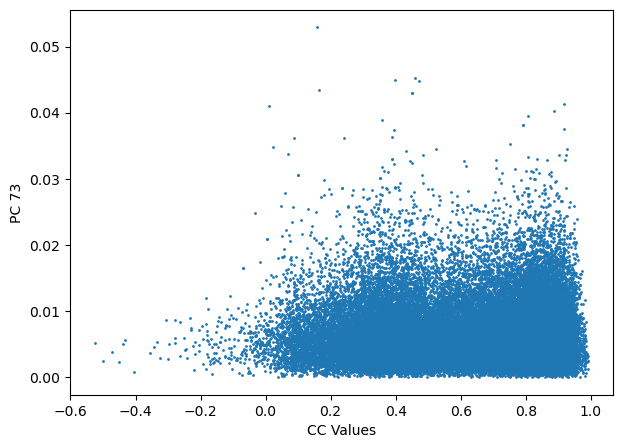

<Figure size 640x480 with 0 Axes>

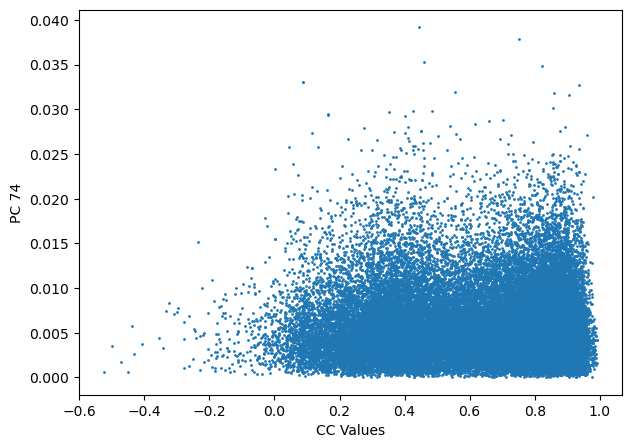

<Figure size 640x480 with 0 Axes>

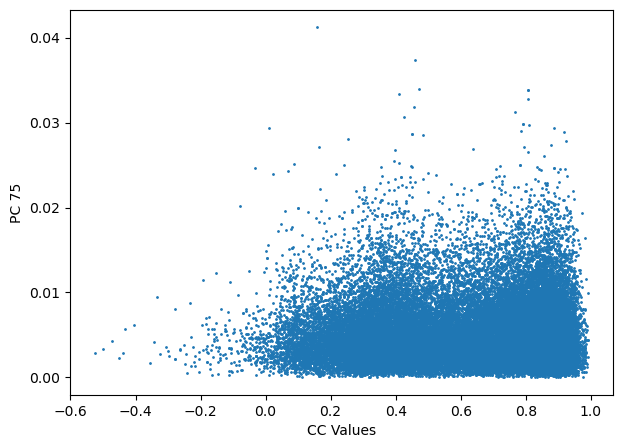

<Figure size 640x480 with 0 Axes>

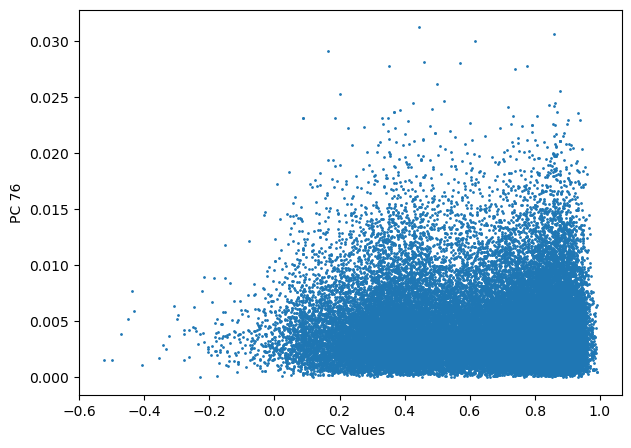

<Figure size 640x480 with 0 Axes>

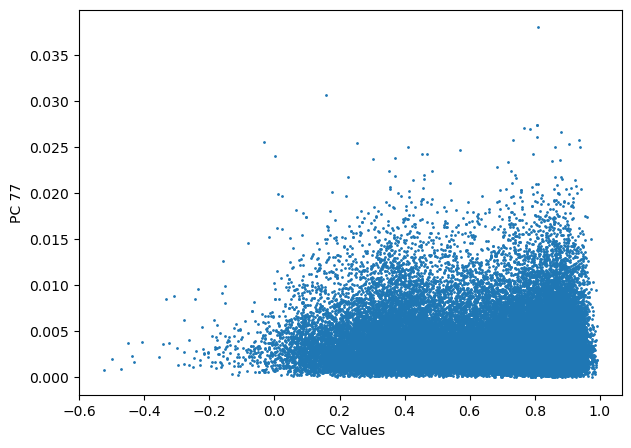

<Figure size 640x480 with 0 Axes>

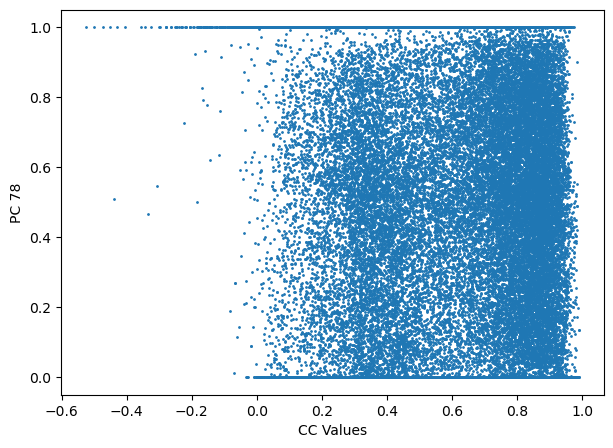

<Figure size 640x480 with 0 Axes>

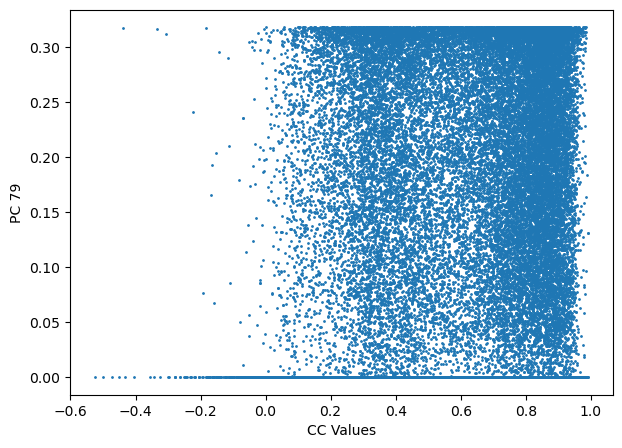

<Figure size 640x480 with 0 Axes>

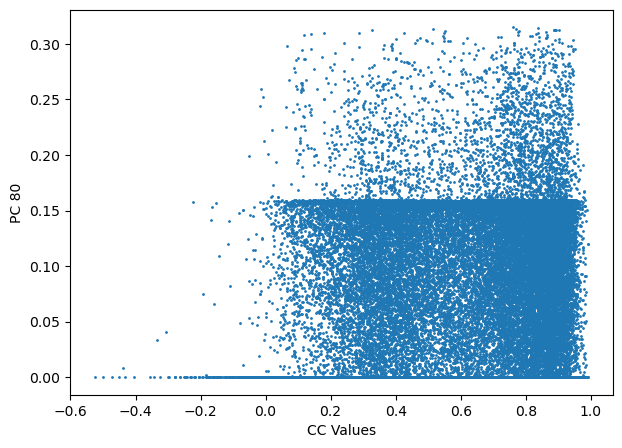

<Figure size 640x480 with 0 Axes>

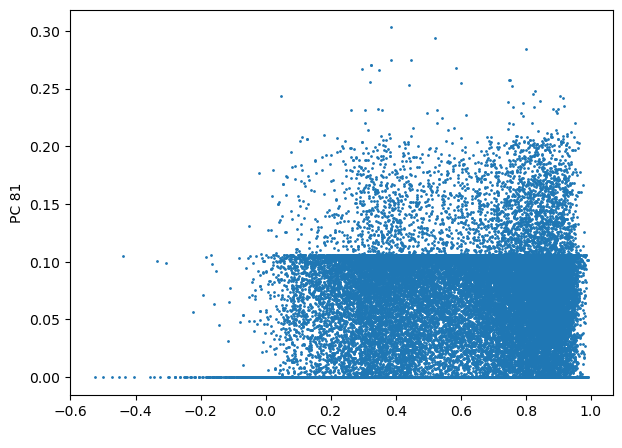

<Figure size 640x480 with 0 Axes>

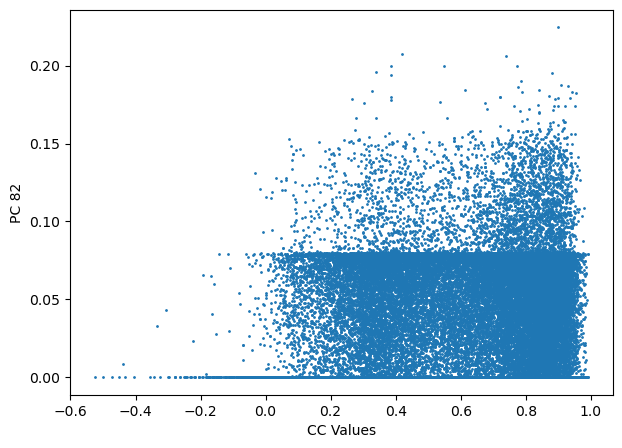

<Figure size 640x480 with 0 Axes>

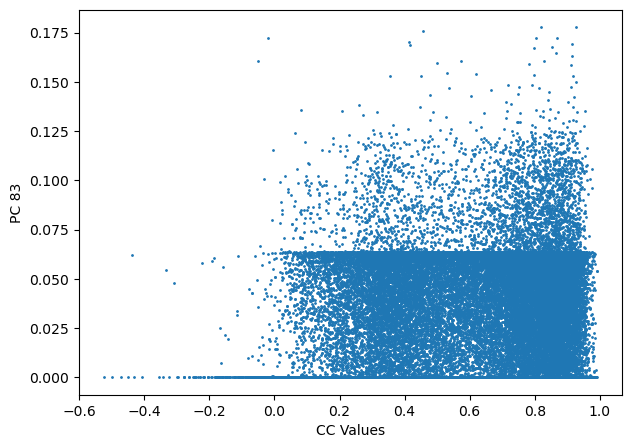

<Figure size 640x480 with 0 Axes>

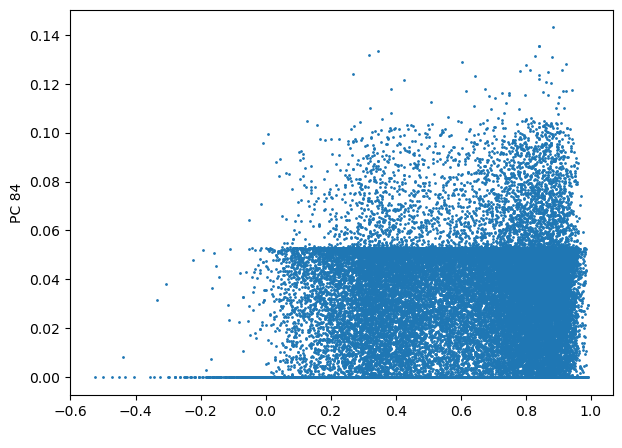

<Figure size 640x480 with 0 Axes>

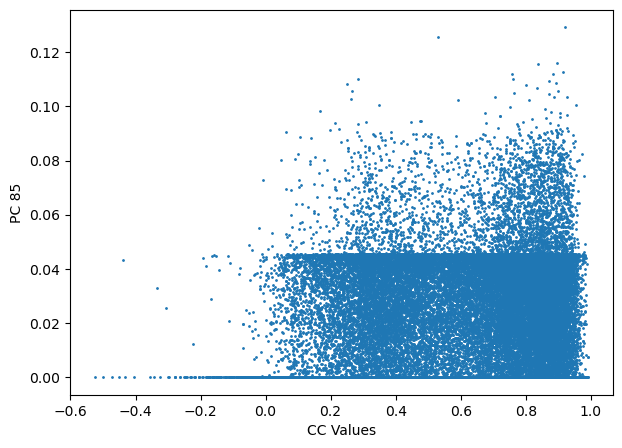

<Figure size 640x480 with 0 Axes>

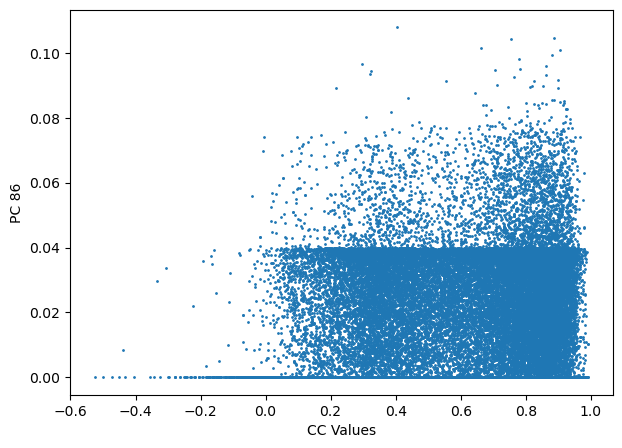

<Figure size 640x480 with 0 Axes>

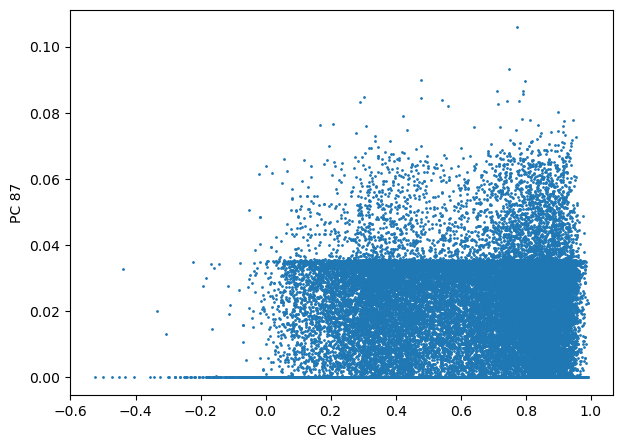

<Figure size 640x480 with 0 Axes>

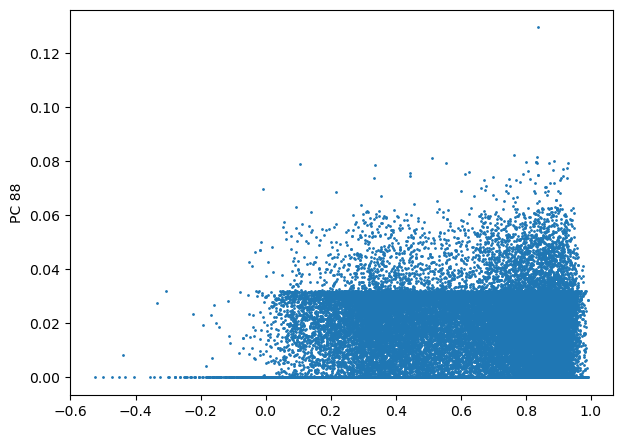

<Figure size 640x480 with 0 Axes>

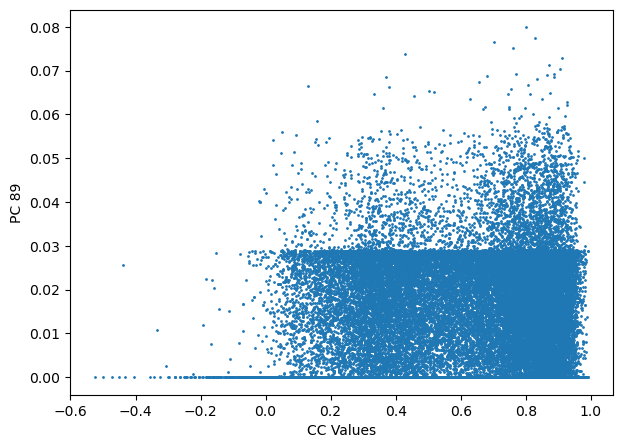

<Figure size 640x480 with 0 Axes>

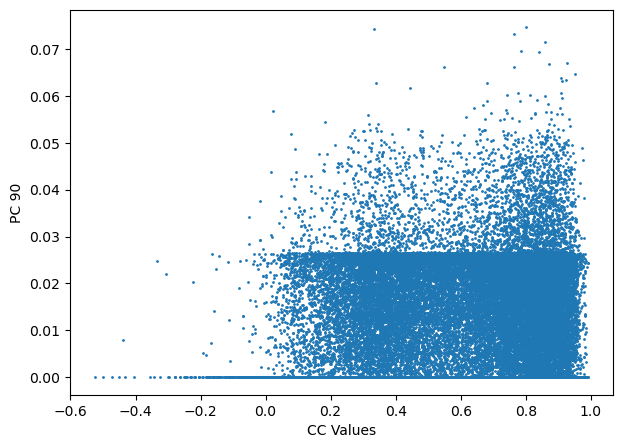

<Figure size 640x480 with 0 Axes>

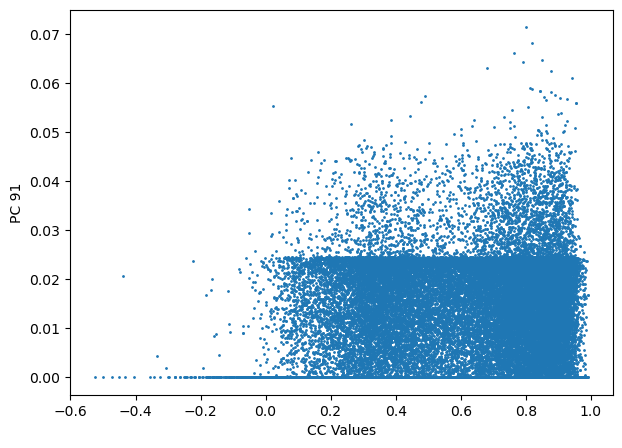

<Figure size 640x480 with 0 Axes>

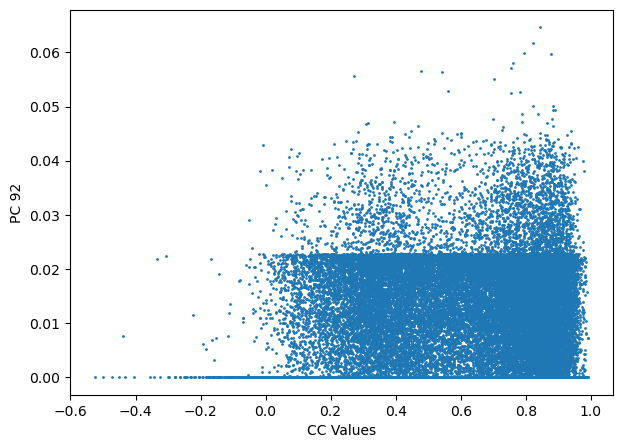

<Figure size 640x480 with 0 Axes>

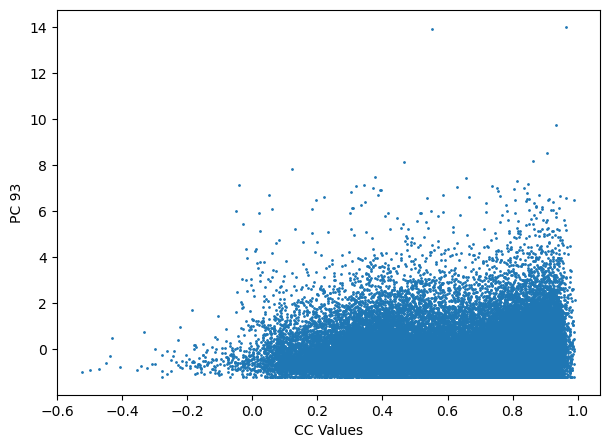

<Figure size 640x480 with 0 Axes>

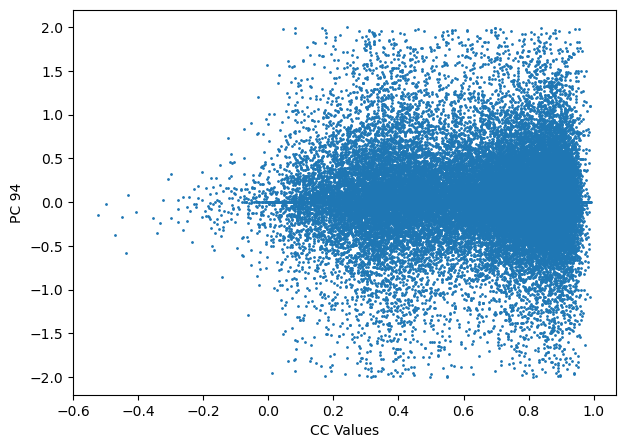

<Figure size 640x480 with 0 Axes>

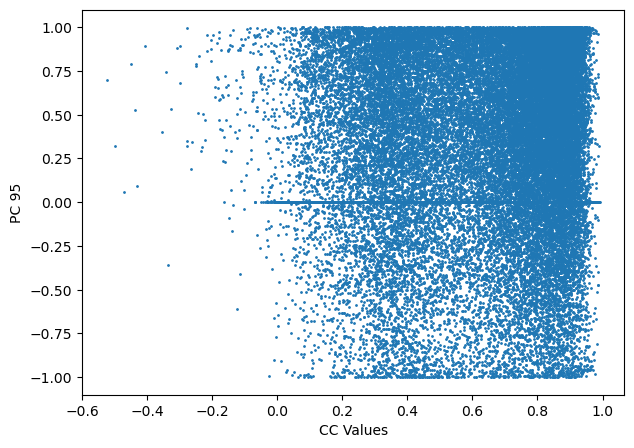

In [21]:
for i in range(95): 
   plt.clf()
   plt.figure(figsize = (7, 5))
   plt.scatter(y, X[:, i], s=1)
   plt.xlabel('CC Values')
   plt.ylabel(f'PC {i+1}')
   plt.pause(0.5)

Split data into training and testing to evaluate performance

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
data = y
variance = np.var(data)
std_dev = np.std(data)
print(f"Variance of the data: {variance}")
print(f"Standard deviation of the data: {std_dev}")

Variance of the data: 0.060413831057238424
Standard deviation of the data: 0.24579225182506959


In [67]:
threshold = 2 * std_dev
mean_data = np.mean(data)
# Identify outliers: Data beyond "mean +/- 2*standard_deviation"
outliers = data[(data < mean_data - threshold) | (data > mean_data + threshold)] 
non_outliers = data[(data >= mean_data - threshold) & (data <= mean_data + threshold)]
print(f"Outliers: {outliers}, Length of Outliars: {len(outliers)}")
print(f"Non-outliers: {non_outliers}, Length of non-outliars: {len(non_outliers)}")

Outliers: [0.13922662 0.12107012 0.1171705  ... 0.138155   0.10706621 0.10706621], Length of Outliars: 1500
Non-outliers: [0.67008646 0.63834953 0.5750558  ... 0.88701831 0.62225098 0.87177603], Length of non-outliars: 43357


In [106]:
non_outlier_condition = (data >= mean_data - threshold) & (data <= mean_data + threshold)
non_outlier_indices = np.where(non_outlier_condition)[0]

In [107]:
cc_vals_non_outliers = y[non_outlier_indices]
X_non_outliers = X[non_outlier_indices]

In [108]:
# Split Non-Outlier Data Into Training & Test Sets 
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_non_outliers, 
                                                                cc_vals_non_outliers,
                                                                test_size = 0.2,
                                                                random_state = 42)

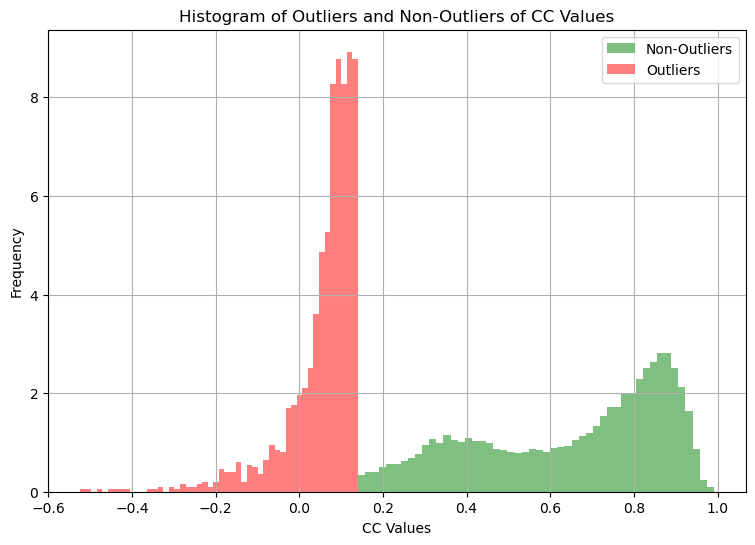

In [97]:
plt.figure(figsize=(9, 6))
plt.hist(non_outliers, bins=n_bins, density = True, alpha=0.5, color = 'g', label='Non-Outliers')
plt.hist(outliers, bins=n_bins,  density = True, alpha=0.5, color='r', label='Outliers')

plt.xlabel('CC Values')
plt.ylabel('Frequency')
plt.title('Histogram of Outliers and Non-Outliers of CC Values')q
plt.legend()
plt.grid(True)
plt.show()

See How Test & Training Sets Differ

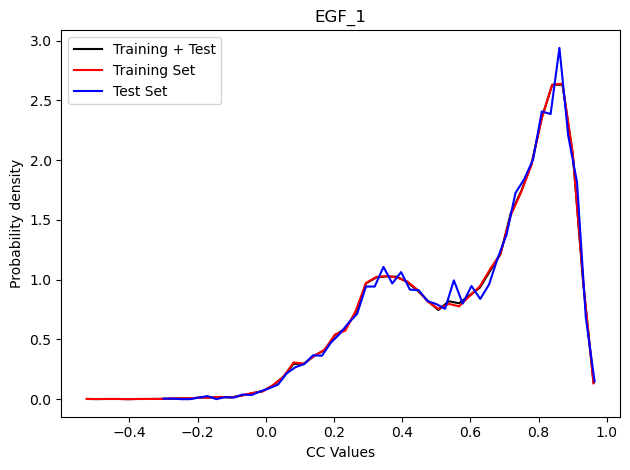

In [61]:
n_bins = 50
counts, bins = np.histogram(y, n_bins, density=True)
plt.plot(bins[:-1], counts, 'k', label = 'Training + Test')
counts, bins = np.histogram(y_train, n_bins, density=True)
plt.plot(bins[:-1], counts, 'r', label = 'Training Set')
counts, bins = np.histogram(y_test, n_bins, density=True)
plt.plot(bins[:-1], counts, 'b', label = 'Test Set')
plt.xlabel('CC Values')
plt.ylabel('Probability density')
plt.title('EGF_1')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

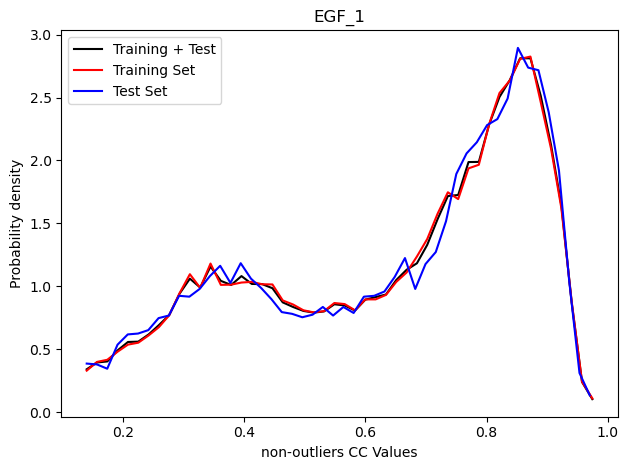

In [109]:
n_bins = 50
counts, bins = np.histogram(cc_vals_non_outliers, n_bins, density=True)
plt.plot(bins[:-1], counts, 'k', label = 'Training + Test')
counts, bins = np.histogram(y_train_no, n_bins, density=True)
plt.plot(bins[:-1], counts, 'r', label = 'Training Set')
counts, bins = np.histogram(y_test_no, n_bins, density=True)
plt.plot(bins[:-1], counts, 'b', label = 'Test Set')
plt.xlabel('non-outliers CC Values')
plt.ylabel('Probability density')
plt.title('EGF_1')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [ ]:
model_lasso = LassoCV(alphas=None, cv=10, max_iter=10000, n_jobs=-1) # Least Absolute Shrinkage and Selection Operator
model_lasso.fit(X_train, y_train)

print(f"Best alpha: {model_lasso.alpha_}") # Best alpha
y_pred_lasso = model_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Mean Squared Error: {mse_lasso}")
#print(f"Coefficients: {model_lasso.coef_}")

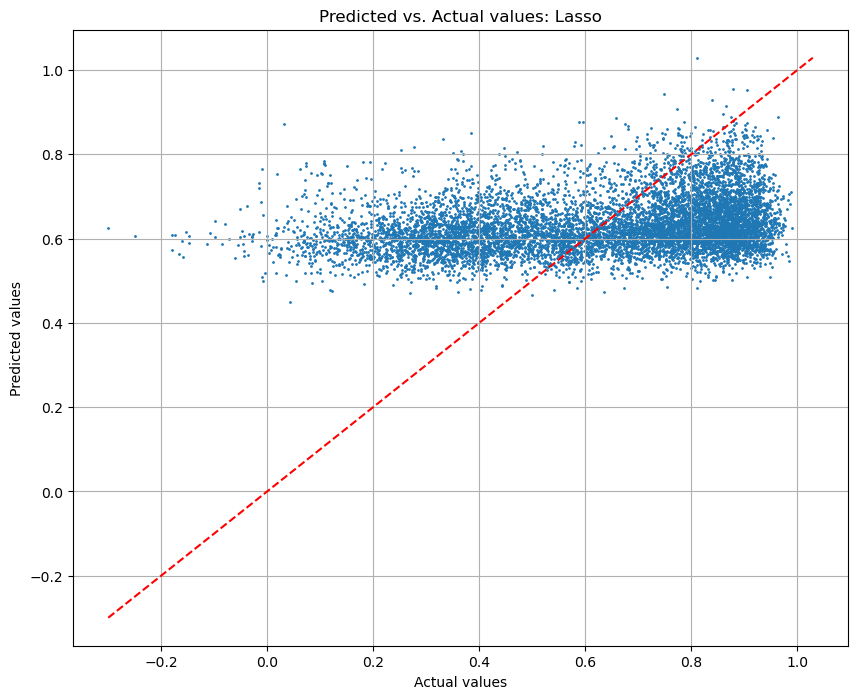

In [139]:
plt.figure(figsize = (10, 8))
plt.scatter(y_test, y_pred_lasso, s=1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted vs. Actual values: Lasso')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test.min(), y_pred_lasso.min())
max_val = max(y_test.max(), y_pred_lasso.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.show()

Best alpha: 1.560363672945436e-05
Mean Squared Error: 0.04739554771999306


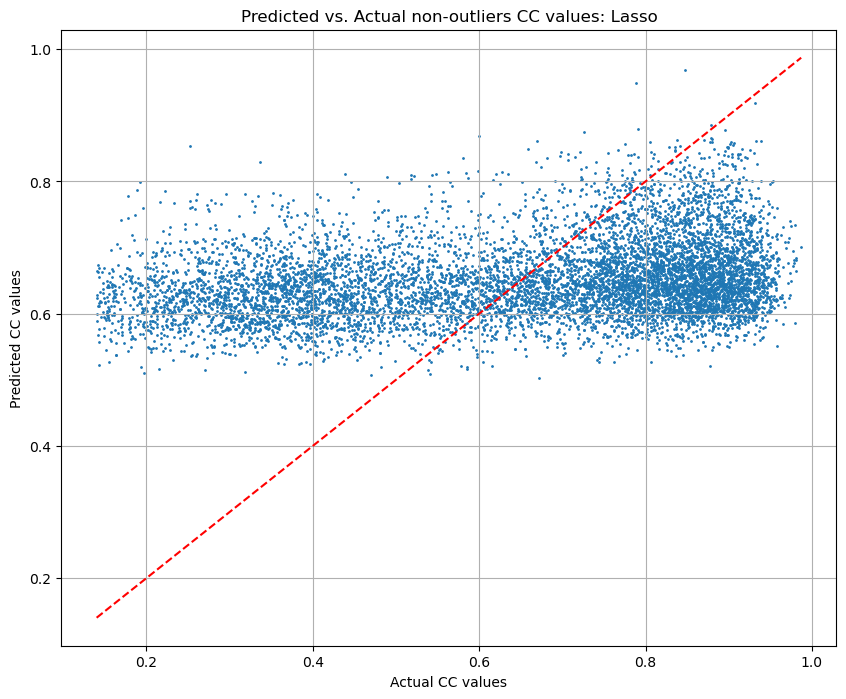

In [117]:
model_lasso = LassoCV(alphas=None, cv=10, max_iter=10000, n_jobs=-1) # Least Absolute Shrinkage and Selection Operator
model_lasso.fit(X_train_no, y_train_no)

print(f"Best alpha: {model_lasso.alpha_}") # Best alpha
y_pred_lasso_no = model_lasso.predict(X_test_no)
mse_lasso_no = mean_squared_error(y_test_no, y_pred_lasso_no)
print(f"Mean Squared Error: {mse_lasso_no}")

plt.figure(figsize = (10, 8))
plt.scatter(y_test_no, y_pred_lasso_no, s=1)
plt.xlabel('Actual CC values')
plt.ylabel('Predicted CC values')
plt.title('Predicted vs. Actual non-outliers CC values: Lasso')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test_no.min(), y_pred_lasso_no.min())
max_val = max(y_test_no.max(), y_pred_lasso_no.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.show()

In [28]:
n_folds_cv = 10
#cv = StratifiedKFold(n_fold_cv) # Stratified K-fold Cross Validations 
cv_kFold = KFold(n_splits = n_folds_cv, # n_splits fold cross-validations 
                 shuffle = True,
                 random_state = 42) # Simple K-fold Cross Validations

Recursive Feature Elimination with Cross Validations 

In [29]:
min_features_to_select =  1
model_linReg = LinearRegression(fit_intercept = True) # Linear regression model
rfecv_linReg = RFECV(estimator=model_linReg,
                     step=1, 
                     cv=cv_kFold, 
                     #scoring="accuracy", 
                     scoring='neg_mean_squared_error',  # Using negative MSE as the scoring method
                     min_features_to_select=1, 
                     n_jobs=-1)

In [ ]:
rfecv_linReg.fit(X_train, y_train) # Recursive Feature Elimination Cross-Validation

y_pred_linReg = rfecv_linReg.predict(X_test) # Predicting the test set results

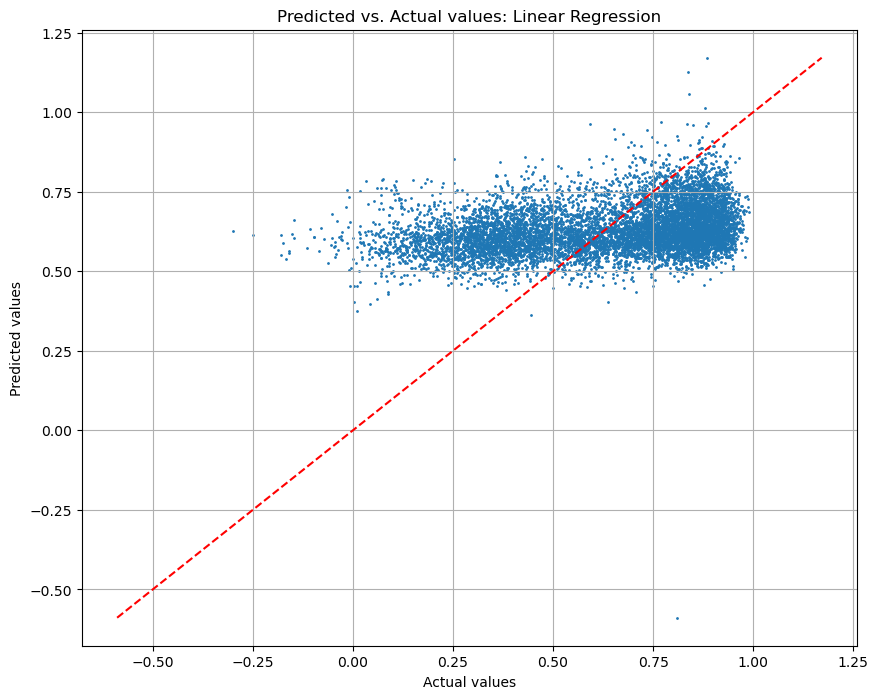

In [138]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_linReg, s = 1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted vs. Actual values: Linear Regression')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test.min(), y_pred_linReg.min())
max_val = max(y_test.max(), y_pred_linReg.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.show()

In [89]:
mse = mean_squared_error(y_test, y_pred_linReg)
r2 = r2_score(y_test, y_pred_linReg)
print(f"Mean Squared Error: {mse} R^2 Score: {r2}")

Mean Squared Error: 0.05395889945447999 R^2 Score: 0.08829203274288733


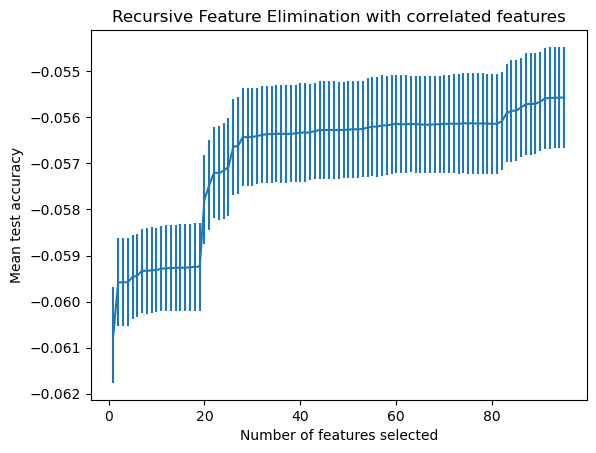

In [90]:
min_features_to_select = 1
n_scores = len(rfecv_linReg.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(range(min_features_to_select, n_scores + min_features_to_select), rfecv_linReg.cv_results_["mean_test_score"], 
             yerr=rfecv_linReg.cv_results_["std_test_score"])
plt.title("Recursive Feature Elimination with correlated features")
plt.show()

In [91]:
print(f"Number of Predictive Features: {rfecv_linReg.n_features_}")
selected_features = np.where(rfecv_linReg.support_ == True)[0] # Identifying the selected features
print(f"Most Predictive Feature Indices:{selected_features}")

Number of Predictive Features: 94
Most Predictive Feature Indices:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 94]


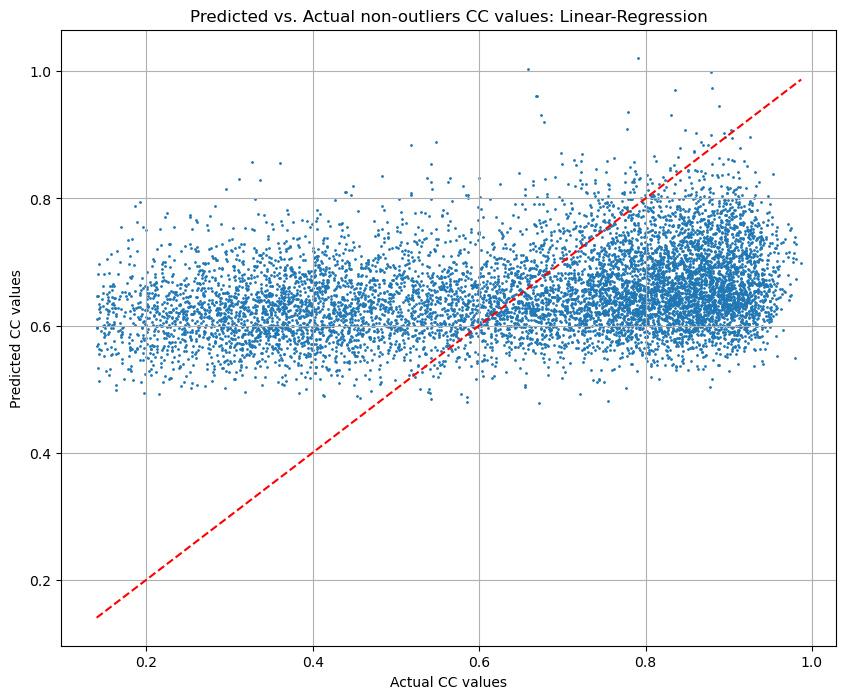

In [118]:
rfecv_linReg.fit(X_train_no, y_train_no) # Recursive Feature Elimination Cross-Validation

y_pred_linReg_no = rfecv_linReg.predict(X_test_no) # Predicting the test set results

plt.figure(figsize=(10, 8))
plt.scatter(y_test_no, y_pred_linReg_no, s = 1)
plt.xlabel('Actual CC values')
plt.ylabel('Predicted CC values')
plt.title('Predicted vs. Actual non-outliers CC values: Linear-Regression')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test_no.min(), y_pred_lasso_no.min())
max_val = max(y_test_no.max(), y_pred_lasso_no.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.show()

Random Forest Regression model

In [123]:
varCutOff = 20
pca = PCA(n_components = varCutOff) 
pca.fit(Xf_rfet) 
Xpca = pca.transform(Xf_rfet)

In [124]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(Xpca,
                                                                y, 
                                                                test_size=0.2, 
                                                                random_state=42)

In [125]:
model_RF_Reg = RandomForestRegressor(n_estimators=40, # Number of Trees 
                                     random_state=42) 

In [126]:
rfecv_RF = RFECV(estimator=model_RF_Reg,
                 step=1, 
                 cv=cv_kFold, 
                 #scoring="accuracy", 
                 scoring='neg_mean_squared_error',  # Using negative MSE as the scoring method
                 min_features_to_select=1,
                 verbose = 1,
                 n_jobs=-1)

In [127]:
rfecv_RF.fit(X_train_rf, y_train_rf) # Recursive Feature Elimination Cross-Validation

Fitting estimator with 20 features.


RFECV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
      estimator=RandomForestRegressor(n_estimators=40, random_state=42),
      n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

In [128]:
y_pred_RF = rfecv_RF.predict(X_test_rf) # Predicting the test set results

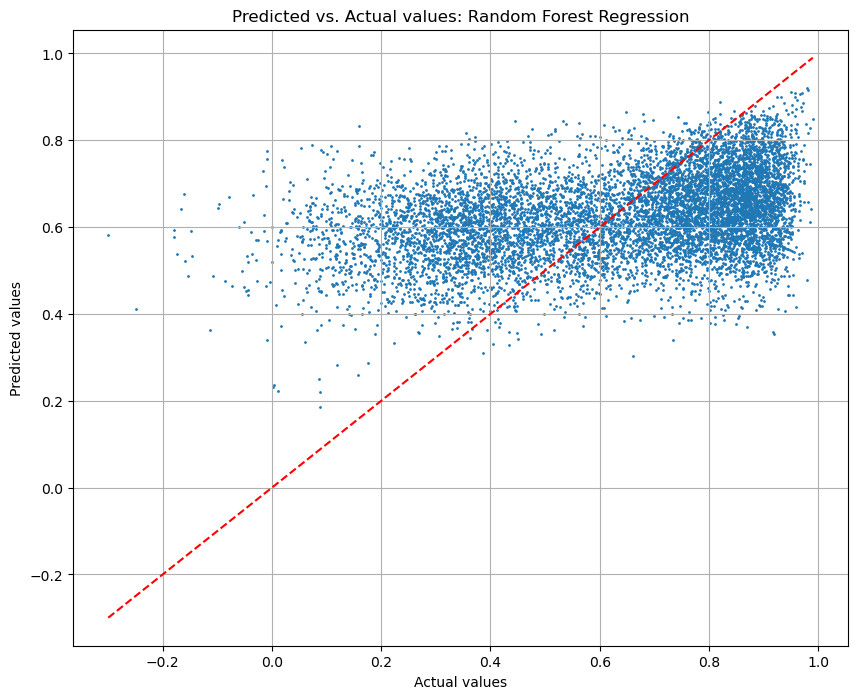

In [132]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test_rf, y_pred_RF, s = 1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted vs. Actual values: Random Forest Regression')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test_rf.min(), y_pred_RF.min())
max_val = max(y_test_rf.max(), y_pred_RF.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.show()

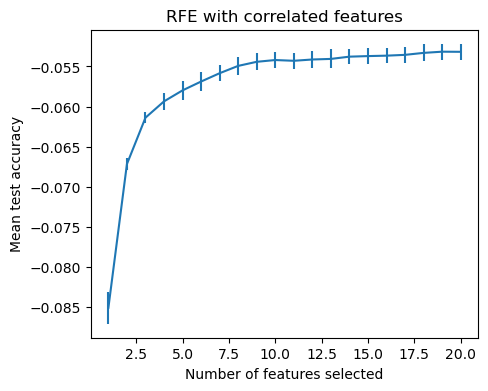

In [130]:
n_scores = len(rfecv_RF.cv_results_["mean_test_score"])
plt.figure(figsize = (5, 4))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(range(min_features_to_select, n_scores + min_features_to_select), rfecv_RF.cv_results_["mean_test_score"], 
             yerr=rfecv_RF.cv_results_["std_test_score"])
plt.title("RFE with correlated features")
plt.show()

In [131]:
print(f"Number of Predictive Features: {rfecv_RF.n_features_}")
selected_features = np.where(rfecv_RF.support_ == True)[0] # Identifying the selected features
print(f"Most Predictive Feature Indices:{selected_features}")

Number of Predictive Features: 19
Most Predictive Feature Indices:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19]
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator w

In [133]:
pca.fit(X_non_outliers) 
Xpca_no = pca.transform(X_non_outliers)

X_train_rf_no, X_test_rf_no, y_train_rf_no, y_test_rf_no = train_test_split(Xpca_no,
                                                                            cc_vals_non_outliers, 
                                                                            test_size = 0.2, 
                                                                            random_state = 42)

In [134]:
rfecv_RF.fit(X_train_rf_no, y_train_rf_no) # Recursive Feature Elimination Cross-Validation

RFECV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
      estimator=RandomForestRegressor(n_estimators=40, random_state=42),
      n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

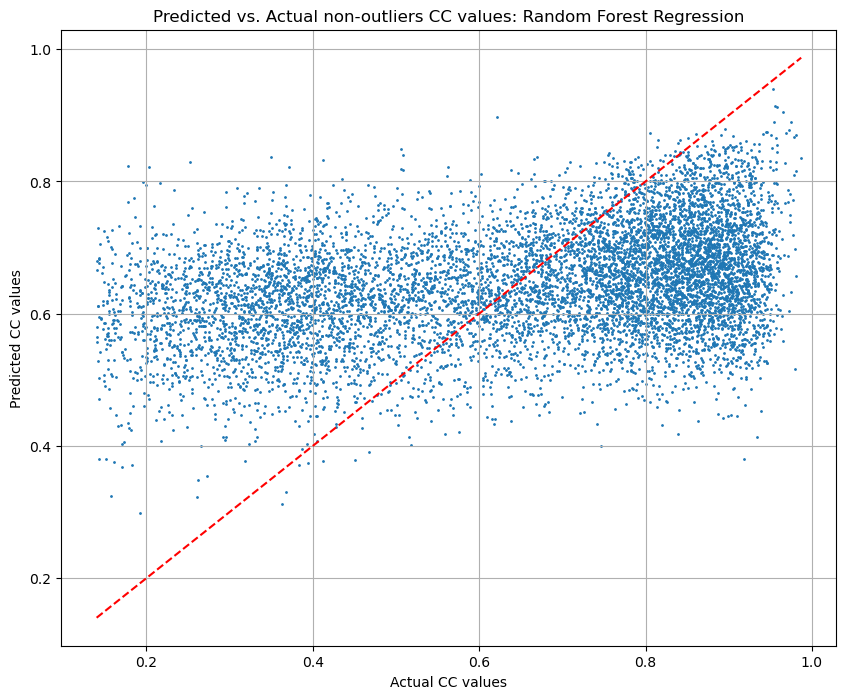

In [135]:
y_pred_RF_no = rfecv_RF.predict(X_test_rf_no) # Predicting the test set results

plt.figure(figsize=(10, 8))
plt.scatter(y_test_rf_no, y_pred_RF_no, s = 1)
plt.xlabel('Actual CC values')
plt.ylabel('Predicted CC values')
plt.title('Predicted vs. Actual non-outliers CC values: Random Forest Regression')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test_rf_no.min(), y_pred_RF_no.min())
max_val = max(y_test_rf_no.max(), y_pred_RF_no.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.show()

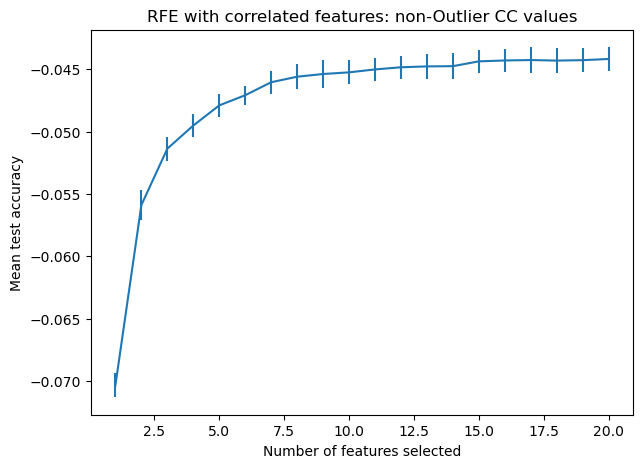

In [137]:
n_scores = len(rfecv_RF.cv_results_["mean_test_score"])
plt.figure(figsize = (7, 5))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(range(min_features_to_select, n_scores + min_features_to_select), rfecv_RF.cv_results_["mean_test_score"], 
             yerr=rfecv_RF.cv_results_["std_test_score"])
plt.title("RFE with correlated features: non-Outlier CC values")
plt.show()

In [ ]:
cc_by_frame = {i: [] for i in range(n_frames)} # Initialize a dictionary to store CC values by frame number
# Aggregate CC values by frame number
for trajectory, frame_list in zip(cross_correlations, frame_numbers):
    for cc, frame in zip(trajectory, frame_list):
            cc_by_frame[frame].append(cc)

avg_cc_frames = []; frames = []
for frame in range(n_frames):
    mean_cc = np.mean(np.array(cc_by_frame[frame]))
    frames.append(frame)
    if mean_cc:  
       avg_cc_frames.append(mean_cc) 
    else:
       avg_cc_frames.append(np.nan)

frames = np.array(frames)
avg_cc_frames = np.array(avg_cc_frames)

plt.clf()
plt.figure(figsize = (10, 6))
plt.plot(frames, avg_cc_frames)
plt.xlabel('Frames')
plt.ylabel('CC Values')
plt.ylim([0.58, 0.72])
plt.title('CC Value by Frame Number')
plt.show()